In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfcsecicids2018v2/NetFlow v2 Features.csv
/kaggle/input/nfcsecicids2018v2/NF-CSE-CIC-IDS2018-V2.parquet


In [2]:
from fastcore.basics import *
from fastcore.parallel import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
from os import cpu_count
from math import floor
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
import shap
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
shap.initjs()

In [3]:
data=pd.read_parquet("/kaggle/input/nfcsecicids2018v2/NF-CSE-CIC-IDS2018-V2.parquet")

## very very Basic EDA

In [4]:
data.dtypes

L4_SRC_PORT                      int32
L4_DST_PORT                      int32
PROTOCOL                          int8
L7_PROTO                       float32
IN_BYTES                         int32
IN_PKTS                          int32
OUT_BYTES                        int32
OUT_PKTS                         int32
TCP_FLAGS                        int16
CLIENT_TCP_FLAGS                 int16
SERVER_TCP_FLAGS                 int16
FLOW_DURATION_MILLISECONDS       int32
DURATION_IN                      int32
DURATION_OUT                     int32
MIN_TTL                          int16
MAX_TTL                          int16
LONGEST_FLOW_PKT                 int32
SHORTEST_FLOW_PKT                int16
MIN_IP_PKT_LEN                   int16
MAX_IP_PKT_LEN                   int32
SRC_TO_DST_SECOND_BYTES        float64
DST_TO_SRC_SECOND_BYTES        float64
RETRANSMITTED_IN_BYTES           int32
RETRANSMITTED_IN_PKTS            int16
RETRANSMITTED_OUT_BYTES          int32
RETRANSMITTED_OUT_PKTS   

In [5]:
data.Label.value_counts()

0    15101685
1     2028030
Name: Label, dtype: int64

In [6]:
data.Attack.value_counts()

Benign                      15101685
DDOS attack-HOIC             1066881
DoS attacks-Hulk              432648
DDoS attacks-LOIC-HTTP        207078
Infilteration                 115513
SSH-Bruteforce                 94979
Bot                            28033
DoS attacks-GoldenEye          27723
FTP-BruteForce                 25933
DoS attacks-SlowHTTPTest       14116
DoS attacks-Slowloris           9512
Brute Force -Web                2143
DDOS attack-LOIC-UDP            2112
Brute Force -XSS                 927
SQL Injection                    432
Name: Attack, dtype: int64

now try to combine all ddoss attacks, all dos attacks and all brute force attacks, sample equealy from all types of ddoss and doss attacks

In [7]:
ddos=data[data['Attack'].str.contains("ddos",case=False)]
dos=data[data['Attack'].str.contains("dos",case=False)]
data.drop(index=dos.index,inplace=True)
dos.drop(index=ddos.index,inplace=True)

brute=data[data['Attack'].str.contains("brute",case=False)]
data.drop(index=brute.index,inplace=True)
print(data.Attack.value_counts())
print("before subsampling")
print(dos.Attack.value_counts())
print(ddos.Attack.value_counts())
print(brute.Attack.value_counts())

grouped = dos.groupby(dos.Attack)
dos_attacks=[ grouped.get_group(attack).sample(9512) for attack in dos.Attack.unique() ]
dos=pd.concat(objs=dos_attacks)

grouped = ddos.groupby(ddos.Attack)
ddos_attacks=[ grouped.get_group(attack).sample(2112) for attack in ddos.Attack.unique() ]
ddos=pd.concat(objs=ddos_attacks)

grouped = brute.groupby(brute.Attack)
brute_attacks=[ grouped.get_group(attack).sample(927) for attack in brute.Attack.unique() ]
brute=pd.concat(objs=brute_attacks)


print("after subsampling")
print(dos.Attack.value_counts())
print(ddos.Attack.value_counts())
print(brute.Attack.value_counts())

dos.Attack="DoS"
ddos.Attack="DDoS"
brute.Attack="Brute Force"
data=pd.concat(objs=[data, dos,ddos,brute])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Benign           15101685
Infilteration      115513
Bot                 28033
SQL Injection         432
Name: Attack, dtype: int64
before subsampling
DoS attacks-Hulk            432648
DoS attacks-GoldenEye        27723
DoS attacks-SlowHTTPTest     14116
DoS attacks-Slowloris         9512
Name: Attack, dtype: int64
DDOS attack-HOIC          1066881
DDoS attacks-LOIC-HTTP     207078
DDOS attack-LOIC-UDP         2112
Name: Attack, dtype: int64
SSH-Bruteforce      94979
FTP-BruteForce      25933
Brute Force -Web     2143
Brute Force -XSS      927
Name: Attack, dtype: int64
after subsampling
DoS attacks-Slowloris       9512
DoS attacks-Hulk            9512
DoS attacks-GoldenEye       9512
DoS attacks-SlowHTTPTest    9512
Name: Attack, dtype: int64
DDoS attacks-LOIC-HTTP    2112
DDOS attack-HOIC          2112
DDOS attack-LOIC-UDP      2112
Name: Attack, dtype: int64
SSH-Bruteforce      927
FTP-BruteForce      927
Brute Force -Web    927
Brute Force -XSS    927
Name: Attack, dtype: int64


In [8]:
# random forest classifier works internally with float32 so values too big will give errors
data = data[data['SRC_TO_DST_SECOND_BYTES'] <= np.finfo(np.float32).max]
data = data[data['DST_TO_SRC_SECOND_BYTES'] <= np.finfo(np.float32).max]

In [9]:
data=data.drop(columns=['L4_SRC_PORT', 'L4_DST_PORT']) # dropping metadata

drop infiltration attacks because of inherently low classification score, results become less reliable when used

In [10]:
data=data[data["Attack"]!="Infilteration"]

## Finding contaminant features using XAI (SHAP)
goal: 
- try to find the contaminant features that have blanked predictive power across all attack classes

method:
* look for shap values per feature that are consistantly high or low among all attack classes.
   
how:
```
possible_contaminants =[]
    while models can achive high accuracy{
    
        * Train a binary classification model (e.g., xgboost) on different attack classes and benign class
        * For each model, calculate shappley values on test set
        * For each model, use np.abs(shap_values).mean(0) to compute the mean absolute SHAP value for each feature across all samples. 
          This will give you a measure of how much each feature contributes to the model output on average across all samples (the importance).
          
        * normalize importances across for each attack class sum of feature importances equals 1
        * for each feature, calculate variance of importance for each attack class
        * for each feature, calculate average importance across all attack classes
        * score of a feature is the weighted sum of the importance and variance
        
        * feature F is feature with the highest score
        * possible_contaminants.append(F)
        * drop F from dataset
    }
```

In [11]:
training_set = data.sample(frac=0.3, replace=False,random_state=42)
# 1%train, 99% test
testing_set = data.drop(index=training_set.index)

In [12]:
training_set.Attack.value_counts()

Benign           4530638
DoS                11228
Bot                 8439
DDoS                1898
Brute Force         1072
SQL Injection        134
Name: Attack, dtype: int64

In [13]:
attacks=training_set.Attack.unique()
attacks

array(['Benign', 'DoS', 'Bot', 'DDoS', 'Brute Force', 'SQL Injection'],
      dtype=object)

### Correlated features

In [14]:
corr = training_set.corr()
corr_features={corr.columns[i] : corr.columns[(np.round(corr,1)>=0.9).iloc[i]].values.tolist() for i in range(0,corr.shape[0])}
corr_list=[]
for key,value in corr_features.items():
#     check if we already have this set
    have_set=False
    for set_s in corr_list:
        if key in set_s:
#             we have found a set
            have_set=True
            break
    if have_set==False and len(value)>1:
        corr_list.append(value)

In [15]:
corr_list

[['IN_BYTES', 'IN_PKTS', 'DURATION_IN', 'NUM_PKTS_UP_TO_128_BYTES'],
 ['OUT_BYTES', 'OUT_PKTS', 'NUM_PKTS_1024_TO_1514_BYTES'],
 ['TCP_FLAGS', 'CLIENT_TCP_FLAGS'],
 ['MIN_TTL', 'MAX_TTL'],
 ['LONGEST_FLOW_PKT', 'MAX_IP_PKT_LEN'],
 ['SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES'],
 ['RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS'],
 ['ICMP_TYPE', 'ICMP_IPV4_TYPE']]

In [16]:
#dropping all but one feature per correlation group
for i in range(len(corr_list)):
    training_set.drop(columns=corr_list[i][1:],inplace=True)
    testing_set.drop(columns=corr_list[i][1:],inplace=True)

### split into dataframes per attack class

In [17]:
grouped = training_set.groupby(training_set.Attack)
dfs={cat:grouped.get_group(cat) for cat in attacks[1:]}
dfs[attacks[0]]=grouped.get_group(attacks[0]) #don't subsample normal attacks
#dfs key=attack_cat, value is dataframe 

In [18]:
# # to make calculations faster
# for k,v in dfs.items():
#     if v.shape[0]>100000:
#         dfs[k]=v.sample(100000,replace=False)

In [19]:
for atk_type in attacks[1:]:
    normals_to_sample = dfs[atk_type].shape[0]
#     print(normals_to_sample)
    normals_sample = dfs['Benign'].sample(normals_to_sample)
#     dfs['Normal'] = dfs['Normal'].drop(index=normals_sample.index)#don't resample
    dfs[atk_type] = pd.concat(objs=[dfs[atk_type], normals_sample])
    print(dfs[atk_type].shape[0], normals_sample.shape[0], dfs['Benign'].shape[0])

22456 11228 4530638
16878 8439 4530638
3796 1898 4530638
2144 1072 4530638
268 134 4530638


In [20]:
testing_dfs = {}
grouped = testing_set.groupby(testing_set.Attack)
testing_dfs={cat:grouped.get_group(cat) for cat in attacks[1:]}
testing_dfs[attacks[0]]=grouped.get_group(attacks[0]) #don't subsample normal attacks
#testing_dfs key=attack_cat, value is dataframe 

In [21]:
# #to make calculations faster
# for k,v in testing_dfs.items():
#     if v.shape[0]>100000:
#         testing_dfs[k]=v.sample(100000,replace=False)

In [22]:
for atk_type in attacks[1:]:
    normals_to_sample = testing_dfs[atk_type].shape[0] 
    normals_sample = testing_dfs['Benign'].sample(normals_to_sample)
#     testing_dfs['Normal'] = testing_dfs['Normal'].drop(index=normals_sample.index)#don't resample
    testing_dfs[atk_type] = pd.concat(objs=[testing_dfs[atk_type], normals_sample])
    print(testing_dfs[atk_type].shape[0], normals_sample.shape[0], testing_dfs['Benign'].shape[0])

53640 26820 10570888
39188 19594 10570888
8772 4386 10570888
5272 2636 10570888
596 298 10570888


In [23]:
print(f"TRAINING SETS")
for k,v in dfs.items():
    v.drop(columns=['Attack'], inplace=True)   
    print(k, v.shape)
    print(v['Label'].value_counts())

TRAINING SETS
DoS (22456, 29)
1    11228
0    11228
Name: Label, dtype: int64
Bot (16878, 29)
1    8439
0    8439
Name: Label, dtype: int64
DDoS (3796, 29)
1    1898
0    1898
Name: Label, dtype: int64
Brute Force (2144, 29)
1    1072
0    1072
Name: Label, dtype: int64
SQL Injection (268, 29)
1    134
0    134
Name: Label, dtype: int64
Benign (4530638, 29)
0    4530638
Name: Label, dtype: int64


In [24]:
print("TESTING SETS")
for k,v in testing_dfs.items():
    v.drop(columns=['Attack'], inplace=True)   
    print(k, v.shape)
    print(v['Label'].value_counts())

TESTING SETS
DoS (53640, 29)
1    26820
0    26820
Name: Label, dtype: int64
Bot (39188, 29)
1    19594
0    19594
Name: Label, dtype: int64
DDoS (8772, 29)
1    4386
0    4386
Name: Label, dtype: int64
Brute Force (5272, 29)
1    2636
0    2636
Name: Label, dtype: int64
SQL Injection (596, 29)
1    298
0    298
Name: Label, dtype: int64
Benign (10570888, 29)
0    10570888
Name: Label, dtype: int64


In [25]:
training_dfs=dfs

ITERATION: 0
['DoS', 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
['Bot', 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
['DDoS', 0.999, 0.0, 1.0, 0.0, 0.999, 0.001]
['Brute Force', 0.998, 0.001, 0.999, 0.0, 0.997, 0.001]
['SQL Injection', 0.989, 0.004, 0.993, 0.004, 0.984, 0.004]
top features ['L7_PROTO', 'FLOW_DURATION_MILLISECONDS', 'TCP_WIN_MAX_IN']
top importances [0.1433394  0.09836859 0.09280236]
 feature to be dropped: L7_PROTO
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 1
['DoS', 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
['Bot', 0.999, 0.0, 0.999, 0.0, 0.999, 0.0]
['DDoS', 0.999, 0.001, 1.0, 0.0, 0.999, 0.001]
['Brute Force', 0.998, 0.0, 0.999, 0.001, 0.996, 0.001]
['SQL Injection', 0.991, 0.004, 0.997, 0.002, 0.985, 0.007]
top features ['MIN_TTL', 'TCP_WIN_MAX_IN', 'FLOW_DURATION_MILLISECONDS']
top importances [0.10775029 0.1050711  0.08601411]
 feature to be dropped: MIN_TTL
 correlated features: [['MIN_TTL', 'MAX_TTL']]


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 2
['DoS', 1.0, 0.0, 0.999, 0.0, 1.0, 0.0]
['Bot', 0.999, 0.0, 1.0, 0.0, 0.999, 0.0]
['DDoS', 0.999, 0.001, 0.999, 0.001, 0.999, 0.001]
['Brute Force', 0.996, 0.001, 0.997, 0.001, 0.995, 0.001]
['SQL Injection', 0.986, 0.003, 0.992, 0.004, 0.979, 0.01]
top features ['TCP_WIN_MAX_IN', 'FLOW_DURATION_MILLISECONDS', 'TCP_WIN_MAX_OUT']
top importances [0.11966824 0.10158197 0.0850319 ]
 feature to be dropped: TCP_WIN_MAX_IN
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 3
['DoS', 0.999, 0.0, 0.999, 0.0, 1.0, 0.0]
['Bot', 0.999, 0.0, 1.0, 0.0, 0.999, 0.0]
['DDoS', 0.998, 0.001, 0.998, 0.001, 0.998, 0.001]
['Brute Force', 0.996, 0.001, 0.997, 0.002, 0.995, 0.001]
['SQL Injection', 0.983, 0.006, 0.993, 0.004, 0.972, 0.011]
top features ['FLOW_DURATION_MILLISECONDS', 'TCP_FLAGS', 'IN_BYTES']
top importances [0.11702679 0.09836284 0.08885555]
 feature to be dropped: FLOW_DURATION_MILLISECONDS
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 4
['DoS', 0.999, 0.0, 0.999, 0.0, 1.0, 0.0]
['Bot', 0.999, 0.0, 1.0, 0.0, 0.999, 0.0]
['DDoS', 0.999, 0.001, 0.999, 0.001, 0.998, 0.001]
['Brute Force', 0.997, 0.001, 0.998, 0.001, 0.996, 0.001]
['SQL Injection', 0.98, 0.008, 0.99, 0.006, 0.97, 0.011]
top features ['TCP_WIN_MAX_OUT', 'IN_BYTES', 'NUM_PKTS_128_TO_256_BYTES']
top importances [0.09570069 0.09563112 0.09250516]
 feature to be dropped: TCP_WIN_MAX_OUT
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 5
['DoS', 0.999, 0.0, 0.999, 0.0, 1.0, 0.0]
['Bot', 0.999, 0.0, 1.0, 0.0, 0.999, 0.0]
['DDoS', 0.999, 0.0, 0.999, 0.0, 0.999, 0.001]
['Brute Force', 0.995, 0.001, 0.995, 0.003, 0.995, 0.001]
['SQL Injection', 0.977, 0.01, 0.989, 0.005, 0.966, 0.016]
top features ['TCP_FLAGS', 'NUM_PKTS_128_TO_256_BYTES', 'IN_BYTES']
top importances [0.11073292 0.10057797 0.09978314]
 feature to be dropped: TCP_FLAGS
 correlated features: [['TCP_FLAGS', 'CLIENT_TCP_FLAGS']]


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 6
['DoS', 0.999, 0.0, 0.999, 0.0, 1.0, 0.0]
['Bot', 0.999, 0.0, 0.999, 0.0, 0.999, 0.0]
['DDoS', 0.994, 0.0, 0.999, 0.001, 0.989, 0.0]
['Brute Force', 0.994, 0.002, 0.994, 0.003, 0.995, 0.001]
['SQL Injection', 0.977, 0.007, 0.987, 0.006, 0.967, 0.01]
top features ['NUM_PKTS_128_TO_256_BYTES', 'IN_BYTES', 'LONGEST_FLOW_PKT']
top importances [0.12049052 0.10361321 0.09044266]
 feature to be dropped: NUM_PKTS_128_TO_256_BYTES
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 7
['DoS', 0.999, 0.0, 0.998, 0.0, 0.999, 0.0]
['Bot', 0.999, 0.0, 0.999, 0.0, 0.998, 0.0]
['DDoS', 0.994, 0.001, 0.999, 0.001, 0.99, 0.001]
['Brute Force', 0.994, 0.001, 0.995, 0.002, 0.994, 0.001]
['SQL Injection', 0.966, 0.004, 0.974, 0.008, 0.957, 0.007]
top features ['IN_BYTES', 'DURATION_OUT', 'LONGEST_FLOW_PKT']
top importances [0.12618982 0.11597446 0.09357265]
 feature to be dropped: IN_BYTES
 correlated features: [['IN_BYTES', 'IN_PKTS', 'DURATION_IN', 'NUM_PKTS_UP_TO_128_BYTES']]


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 8
['DoS', 0.999, 0.0, 0.998, 0.0, 0.999, 0.0]
['Bot', 0.999, 0.0, 0.999, 0.0, 0.999, 0.0]
['DDoS', 0.994, 0.001, 0.999, 0.002, 0.989, 0.0]
['Brute Force', 0.995, 0.001, 0.995, 0.002, 0.994, 0.001]
['SQL Injection', 0.966, 0.006, 0.979, 0.01, 0.954, 0.012]
top features ['DURATION_OUT', 'LONGEST_FLOW_PKT', 'SRC_TO_DST_SECOND_BYTES']
top importances [0.12744341 0.10856717 0.10762733]
 feature to be dropped: DURATION_OUT
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 9
['DoS', 0.999, 0.0, 0.998, 0.0, 0.999, 0.0]
['Bot', 0.999, 0.0, 0.999, 0.0, 0.998, 0.0]
['DDoS', 0.994, 0.0, 0.999, 0.001, 0.99, 0.001]
['Brute Force', 0.995, 0.002, 0.995, 0.004, 0.995, 0.0]
['SQL Injection', 0.972, 0.007, 0.983, 0.007, 0.961, 0.009]
top features ['LONGEST_FLOW_PKT', 'SRC_TO_DST_AVG_THROUGHPUT', 'OUT_BYTES']
top importances [0.13779697 0.12348869 0.1130544 ]
 feature to be dropped: LONGEST_FLOW_PKT
 correlated features: [['LONGEST_FLOW_PKT', 'MAX_IP_PKT_LEN']]


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 10
['DoS', 0.998, 0.0, 0.997, 0.0, 0.999, 0.0]
['Bot', 0.999, 0.0, 0.999, 0.0, 0.998, 0.0]
['DDoS', 0.994, 0.0, 0.999, 0.0, 0.989, 0.0]
['Brute Force', 0.994, 0.001, 0.993, 0.001, 0.995, 0.001]
['SQL Injection', 0.966, 0.005, 0.979, 0.009, 0.953, 0.008]
top features ['SRC_TO_DST_AVG_THROUGHPUT', 'SRC_TO_DST_SECOND_BYTES', 'OUT_BYTES']
top importances [0.14811349 0.13221346 0.13273839]
 feature to be dropped: SRC_TO_DST_AVG_THROUGHPUT
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 11
['DoS', 0.999, 0.0, 0.998, 0.0, 0.999, 0.0]
['Bot', 0.999, 0.0, 0.999, 0.0, 0.999, 0.0]
['DDoS', 0.994, 0.0, 1.0, 0.0, 0.989, 0.0]
['Brute Force', 0.995, 0.001, 0.994, 0.002, 0.995, 0.001]
['SQL Injection', 0.976, 0.003, 0.991, 0.004, 0.96, 0.007]
top features ['OUT_BYTES', 'DST_TO_SRC_AVG_THROUGHPUT', 'SRC_TO_DST_SECOND_BYTES']
top importances [0.16783709 0.14700576 0.14171965]
 feature to be dropped: OUT_BYTES
 correlated features: [['OUT_BYTES', 'OUT_PKTS', 'NUM_PKTS_1024_TO_1514_BYTES']]


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 12
['DoS', 0.999, 0.0, 0.998, 0.0, 0.999, 0.0]
['Bot', 0.999, 0.0, 0.998, 0.0, 0.999, 0.0]
['DDoS', 0.993, 0.001, 0.997, 0.001, 0.989, 0.0]
['Brute Force', 0.994, 0.001, 0.993, 0.002, 0.995, 0.001]
['SQL Injection', 0.97, 0.002, 0.979, 0.006, 0.961, 0.007]
top features ['SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_AVG_THROUGHPUT', 'SERVER_TCP_FLAGS']
top importances [0.18393318 0.18135367 0.1474276 ]
 feature to be dropped: SRC_TO_DST_SECOND_BYTES
 correlated features: [['SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES']]


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 13
['DoS', 0.998, 0.0, 0.996, 0.0, 0.999, 0.0]
['Bot', 0.998, 0.0, 0.997, 0.001, 0.998, 0.001]
['DDoS', 0.992, 0.001, 0.995, 0.002, 0.989, 0.0]
['Brute Force', 0.992, 0.002, 0.989, 0.003, 0.996, 0.0]
['SQL Injection', 0.967, 0.005, 0.975, 0.012, 0.959, 0.006]
top features ['DST_TO_SRC_AVG_THROUGHPUT', 'SERVER_TCP_FLAGS', 'NUM_PKTS_512_TO_1024_BYTES']
top importances [0.20657944 0.177194   0.12675473]
 feature to be dropped: DST_TO_SRC_AVG_THROUGHPUT
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 14
['DoS', 0.989, 0.0, 0.994, 0.001, 0.985, 0.0]
['Bot', 0.988, 0.0, 0.977, 0.0, 0.999, 0.0]
['DDoS', 0.982, 0.001, 0.976, 0.001, 0.989, 0.0]
['Brute Force', 0.985, 0.001, 0.974, 0.001, 0.996, 0.0]
['SQL Injection', 0.965, 0.006, 0.955, 0.014, 0.977, 0.004]
top features ['SERVER_TCP_FLAGS', 'NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_256_TO_512_BYTES']
top importances [0.28593067 0.14805601 0.10495115]
 feature to be dropped: SERVER_TCP_FLAGS
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 15
['DoS', 0.947, 0.0, 0.917, 0.001, 0.983, 0.001]
['Bot', 0.967, 0.0, 0.964, 0.0, 0.97, 0.0]
['DDoS', 0.906, 0.001, 0.848, 0.001, 0.989, 0.0]
['Brute Force', 0.887, 0.0, 0.817, 0.001, 0.996, 0.0]
['SQL Injection', 0.87, 0.009, 0.82, 0.024, 0.951, 0.039]
top features ['NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_256_TO_512_BYTES', 'SHORTEST_FLOW_PKT']
top importances [0.21744306 0.17030562 0.10780014]
 feature to be dropped: NUM_PKTS_512_TO_1024_BYTES
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 16
['DoS', 0.924, 0.0, 0.883, 0.0, 0.978, 0.0]
['Bot', 0.878, 0.0, 0.82, 0.0, 0.969, 0.0]
['DDoS', 0.843, 0.003, 0.764, 0.006, 0.994, 0.004]
['Brute Force', 0.851, 0.001, 0.772, 0.0, 0.996, 0.001]
['SQL Injection', 0.855, 0.001, 0.826, 0.002, 0.899, 0.0]
top features ['NUM_PKTS_256_TO_512_BYTES', 'PROTOCOL', 'SHORTEST_FLOW_PKT']
top importances [0.23274888 0.1220366  0.11941733]
 feature to be dropped: NUM_PKTS_256_TO_512_BYTES
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 17
['DoS', 0.86, 0.0, 0.993, 0.0, 0.725, 0.0]
['Bot', 0.818, 0.0, 0.733, 0.0, 1.0, 0.0]
['DDoS', 0.816, 0.001, 0.734, 0.001, 0.991, 0.0]
['Brute Force', 0.817, 0.0, 0.733, 0.0, 0.998, 0.0]
['SQL Injection', 0.821, 0.001, 0.736, 0.001, 1.0, 0.0]
top features ['SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'PROTOCOL']
top importances [0.18099676 0.15650989 0.1545868 ]
 feature to be dropped: SHORTEST_FLOW_PKT
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 18
['DoS', 0.847, 0.0, 0.957, 0.0, 0.726, 0.0]
['Bot', 0.818, 0.0, 0.733, 0.0, 1.0, 0.0]
['DDoS', 0.816, 0.0, 0.734, 0.0, 0.991, 0.0]
['Brute Force', 0.816, 0.001, 0.732, 0.0, 0.997, 0.001]
['SQL Injection', 0.821, 0.001, 0.737, 0.001, 1.0, 0.0]
top features ['MIN_IP_PKT_LEN', 'PROTOCOL', 'DNS_QUERY_ID']
top importances [0.21350397 0.18854451 0.17299403]
 feature to be dropped: MIN_IP_PKT_LEN
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 19
['DoS', 0.804, 0.0, 0.719, 0.0, 1.0, 0.0]
['Bot', 0.803, 0.0, 0.718, 0.0, 1.0, 0.0]
['DDoS', 0.801, 0.0, 0.715, 0.0, 1.0, 0.0]
['Brute Force', 0.8, 0.001, 0.715, 0.0, 0.997, 0.001]
['SQL Injection', 0.792, 0.004, 0.706, 0.004, 1.0, 0.0]


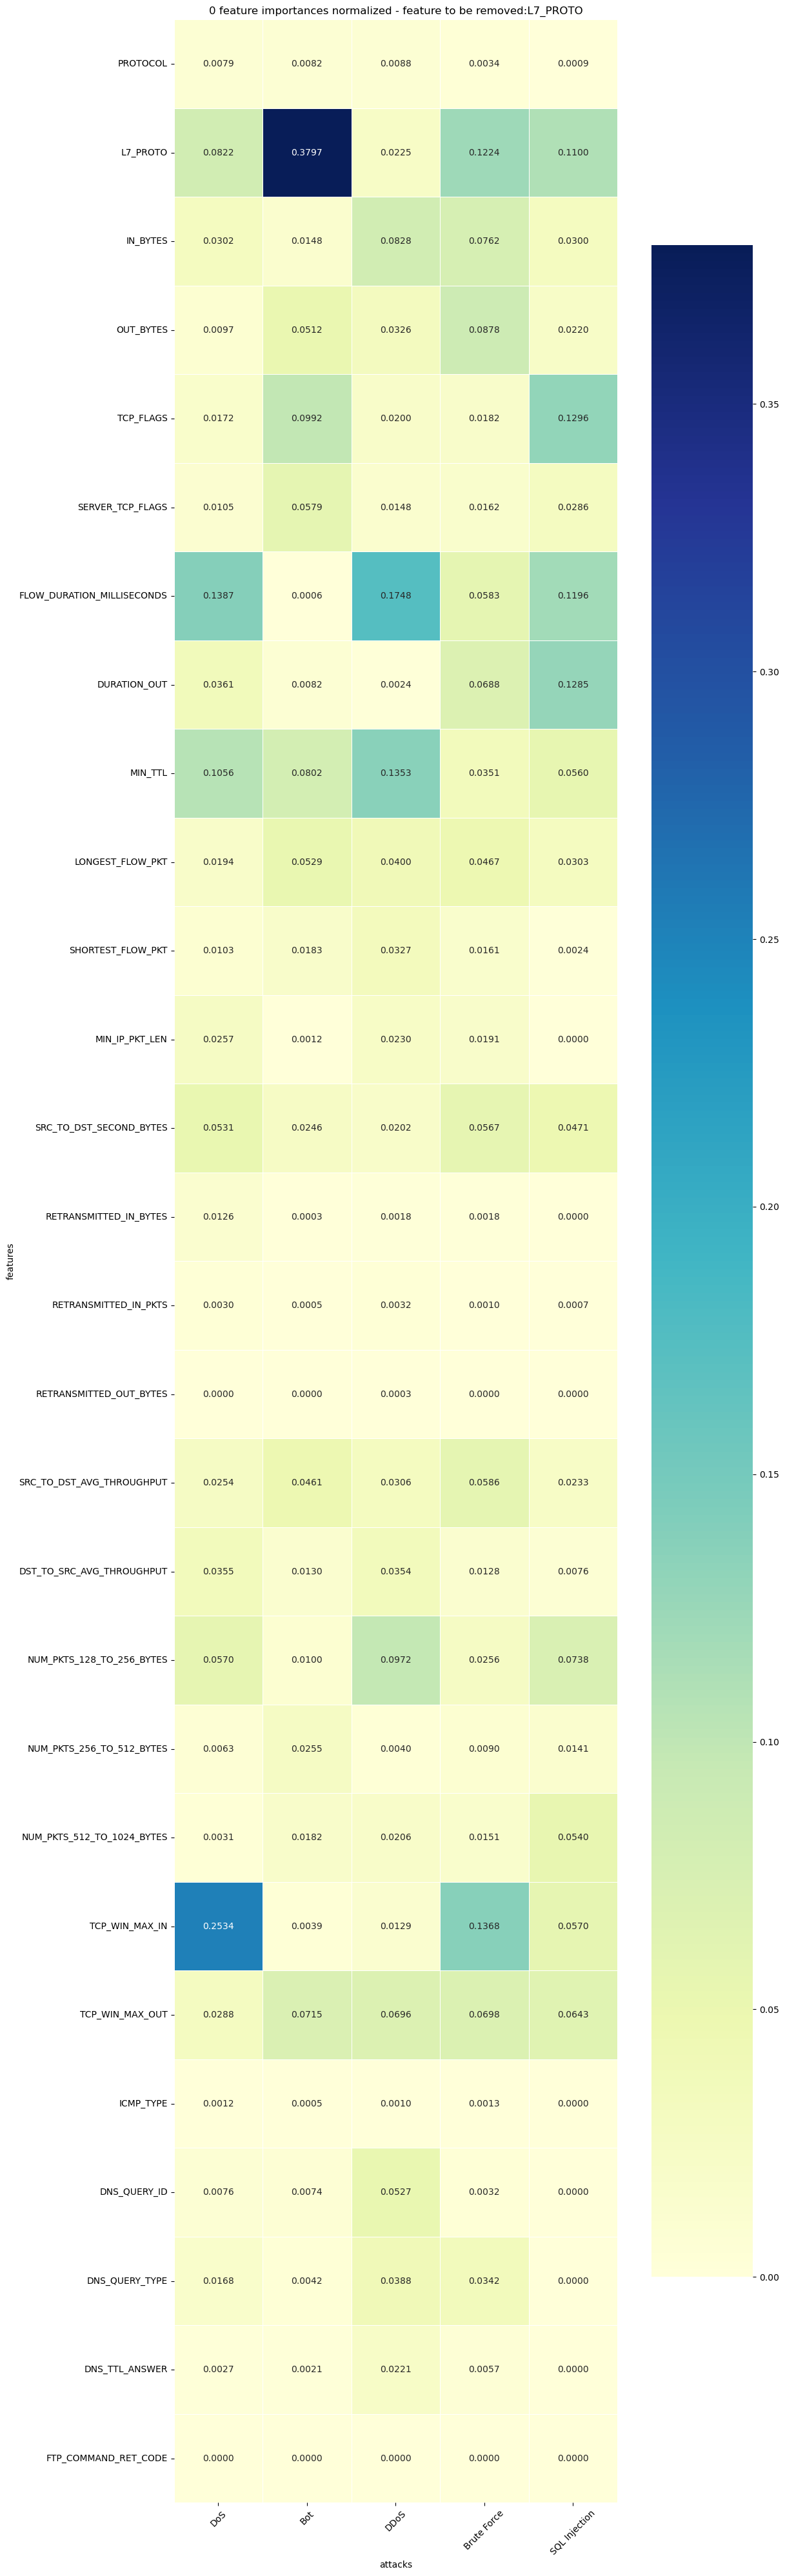

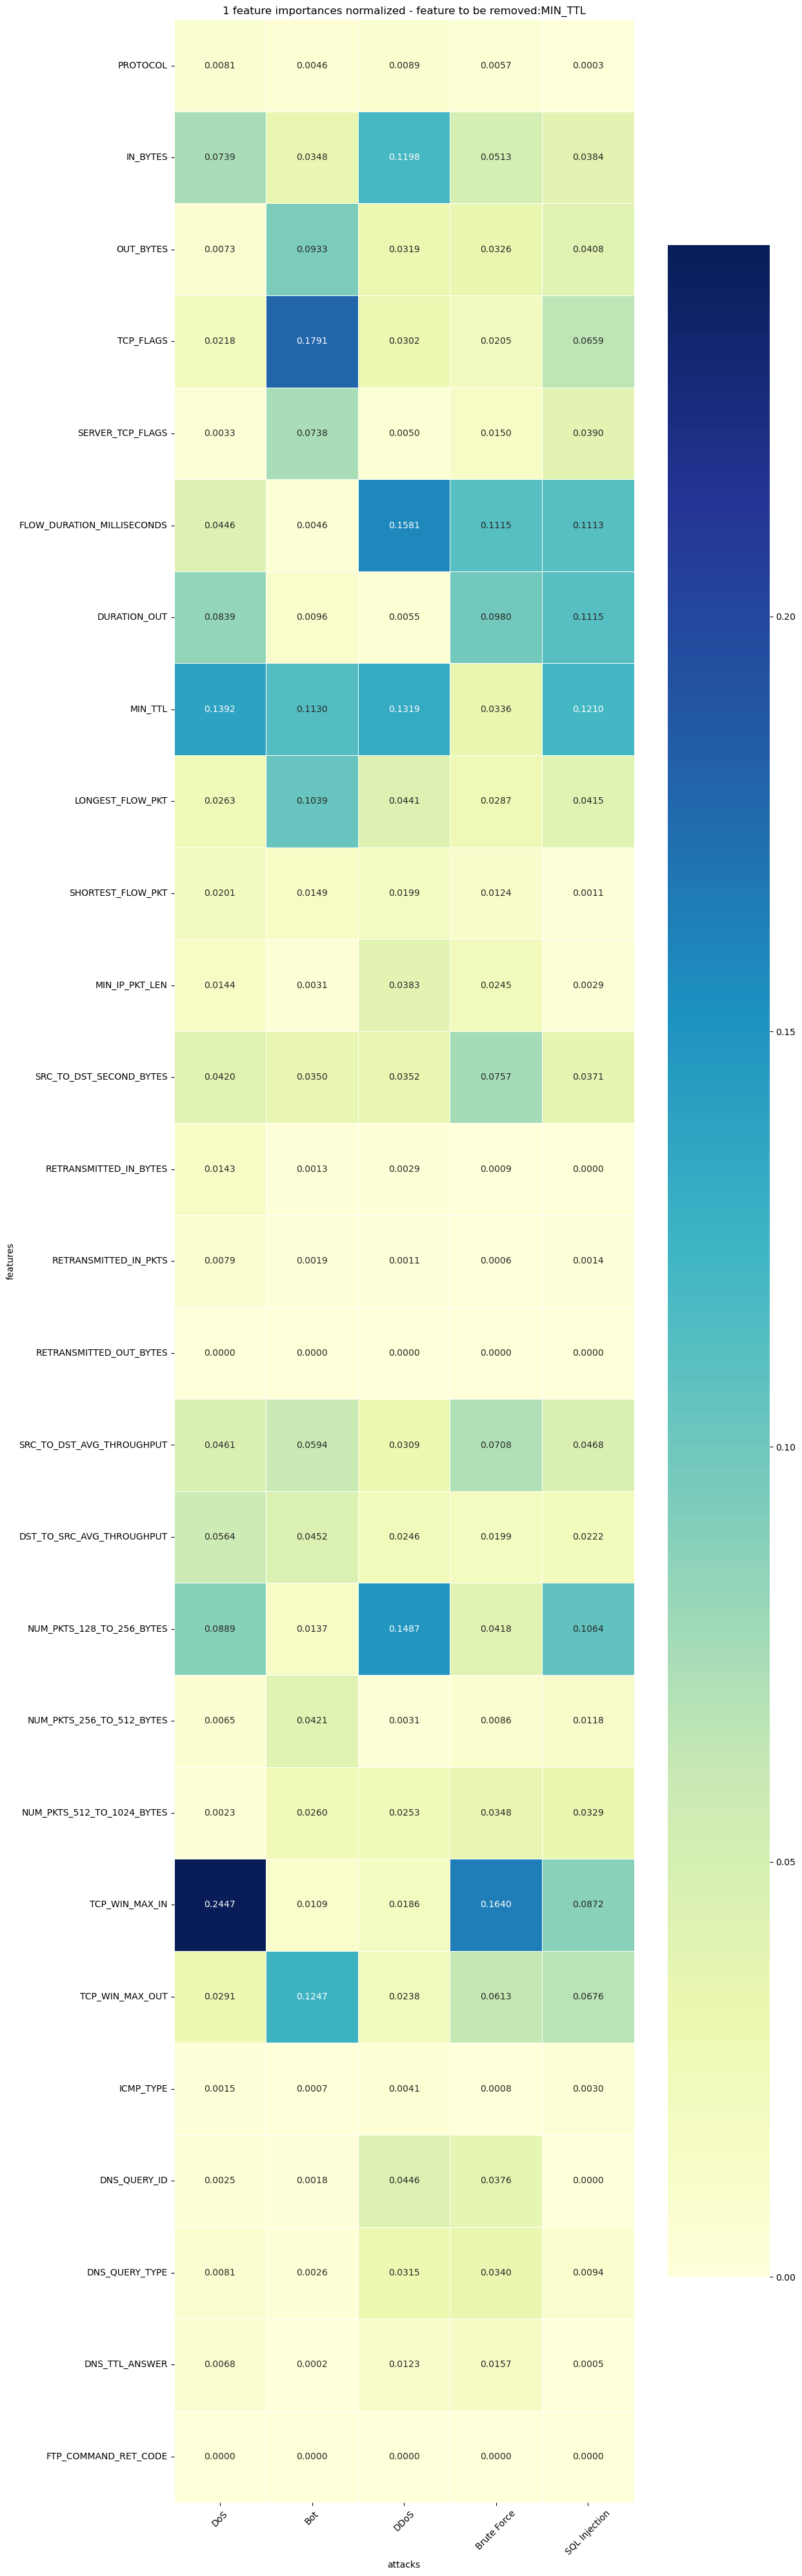

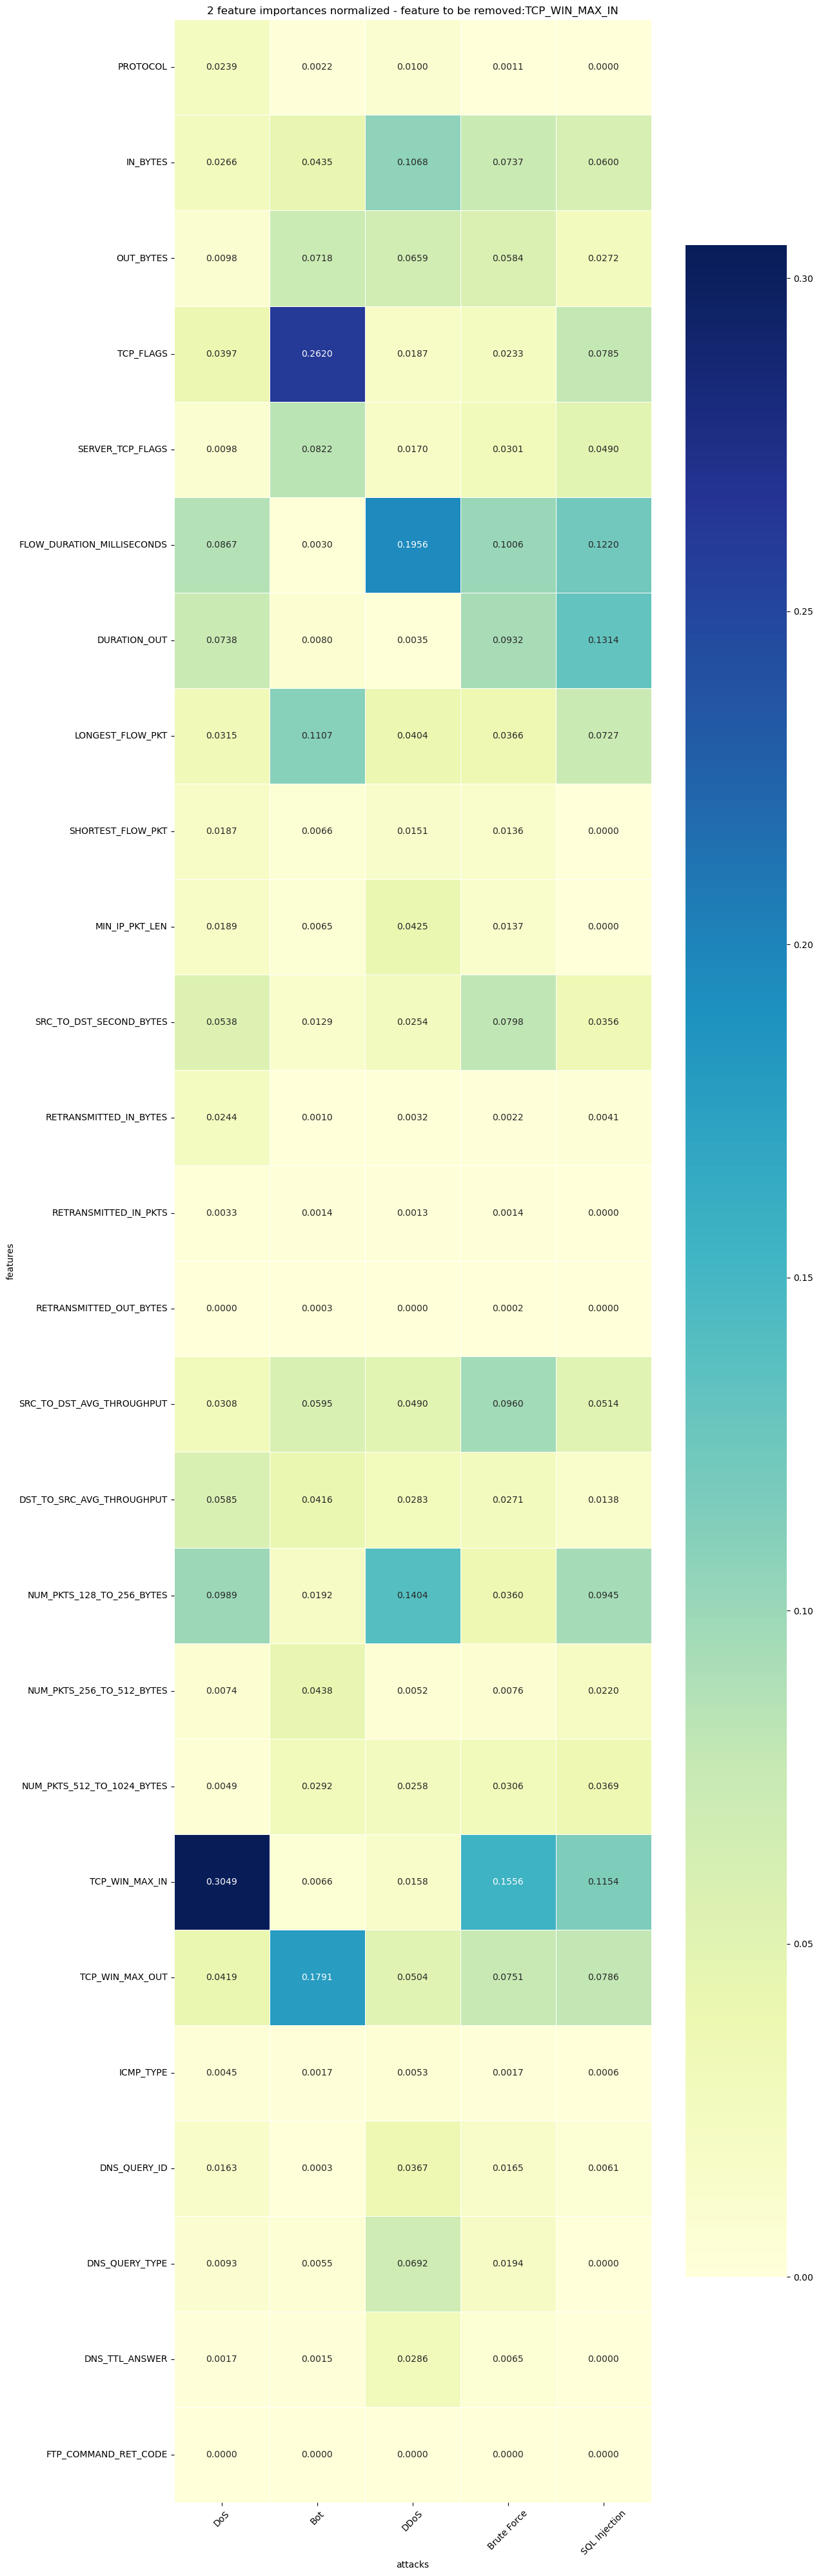

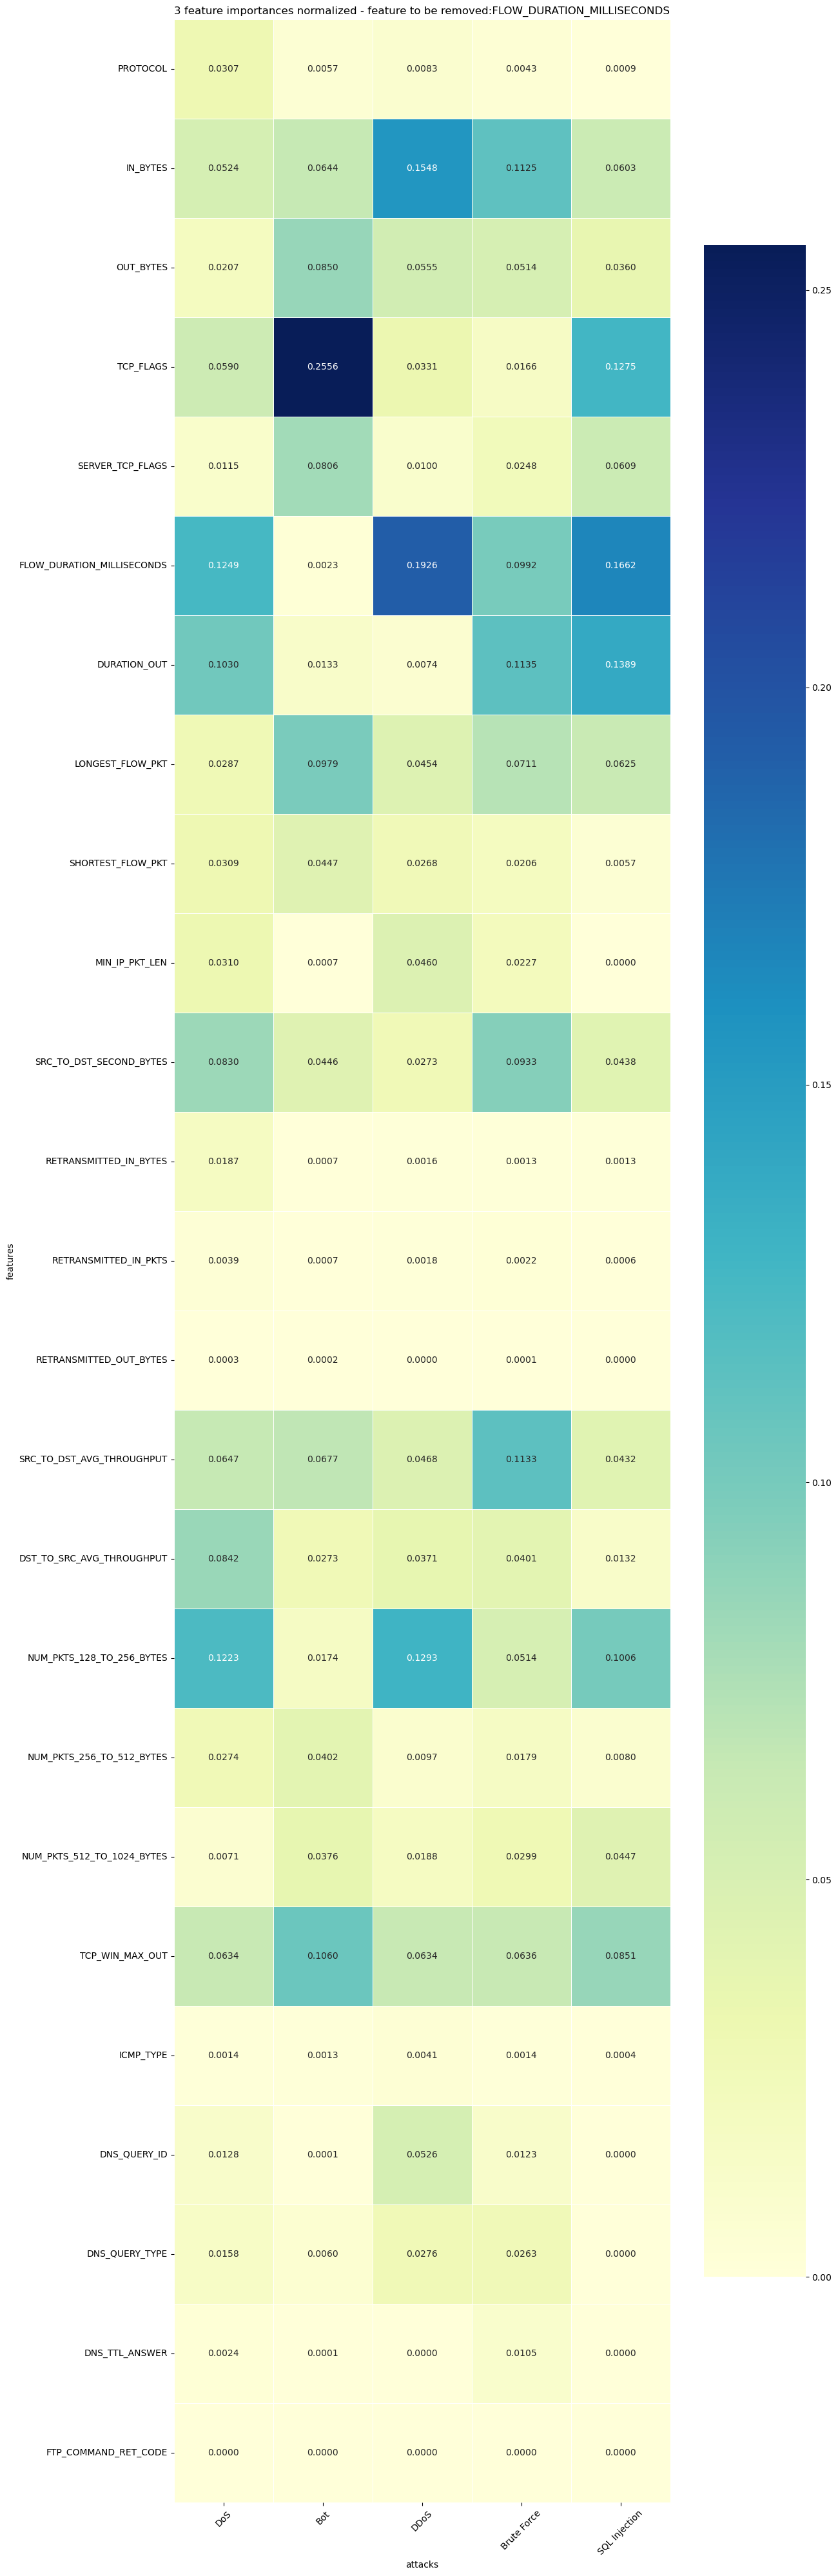

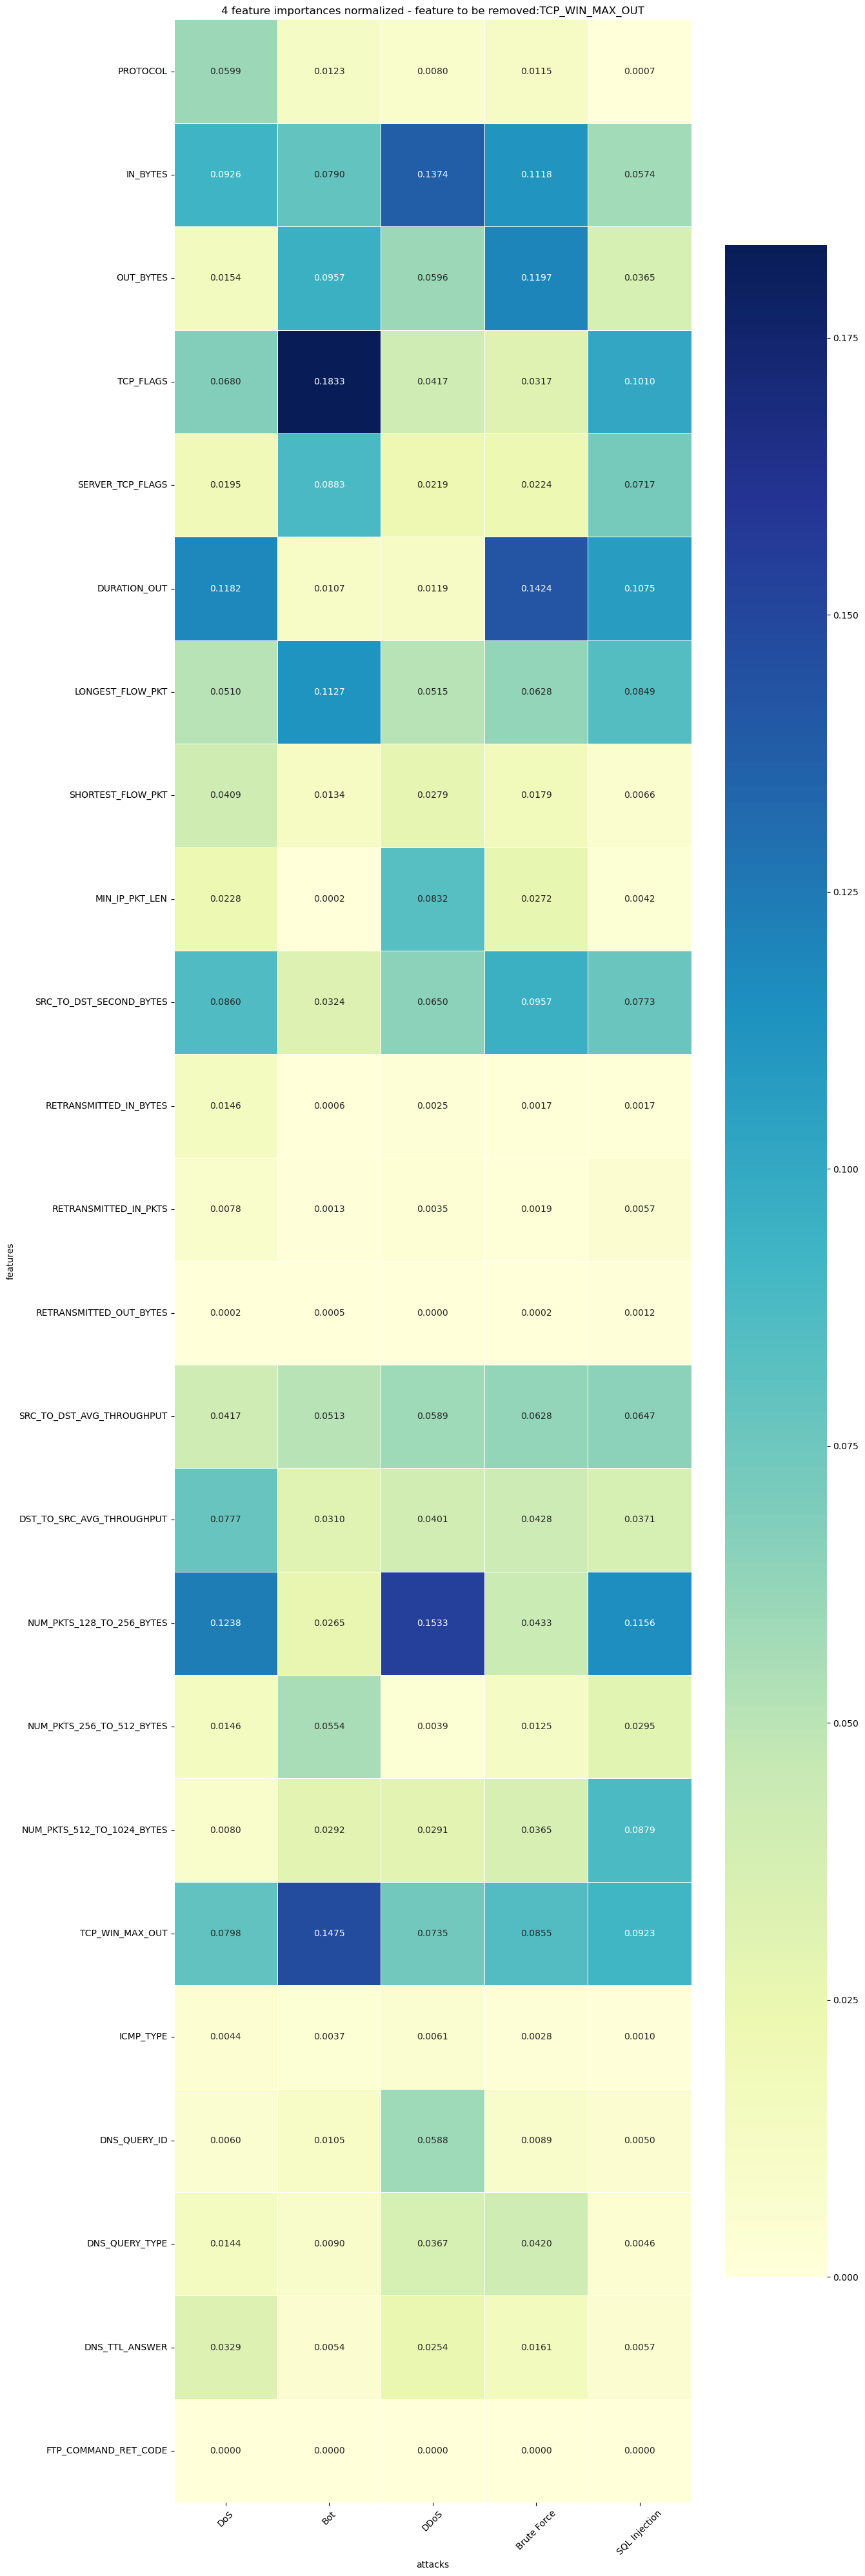

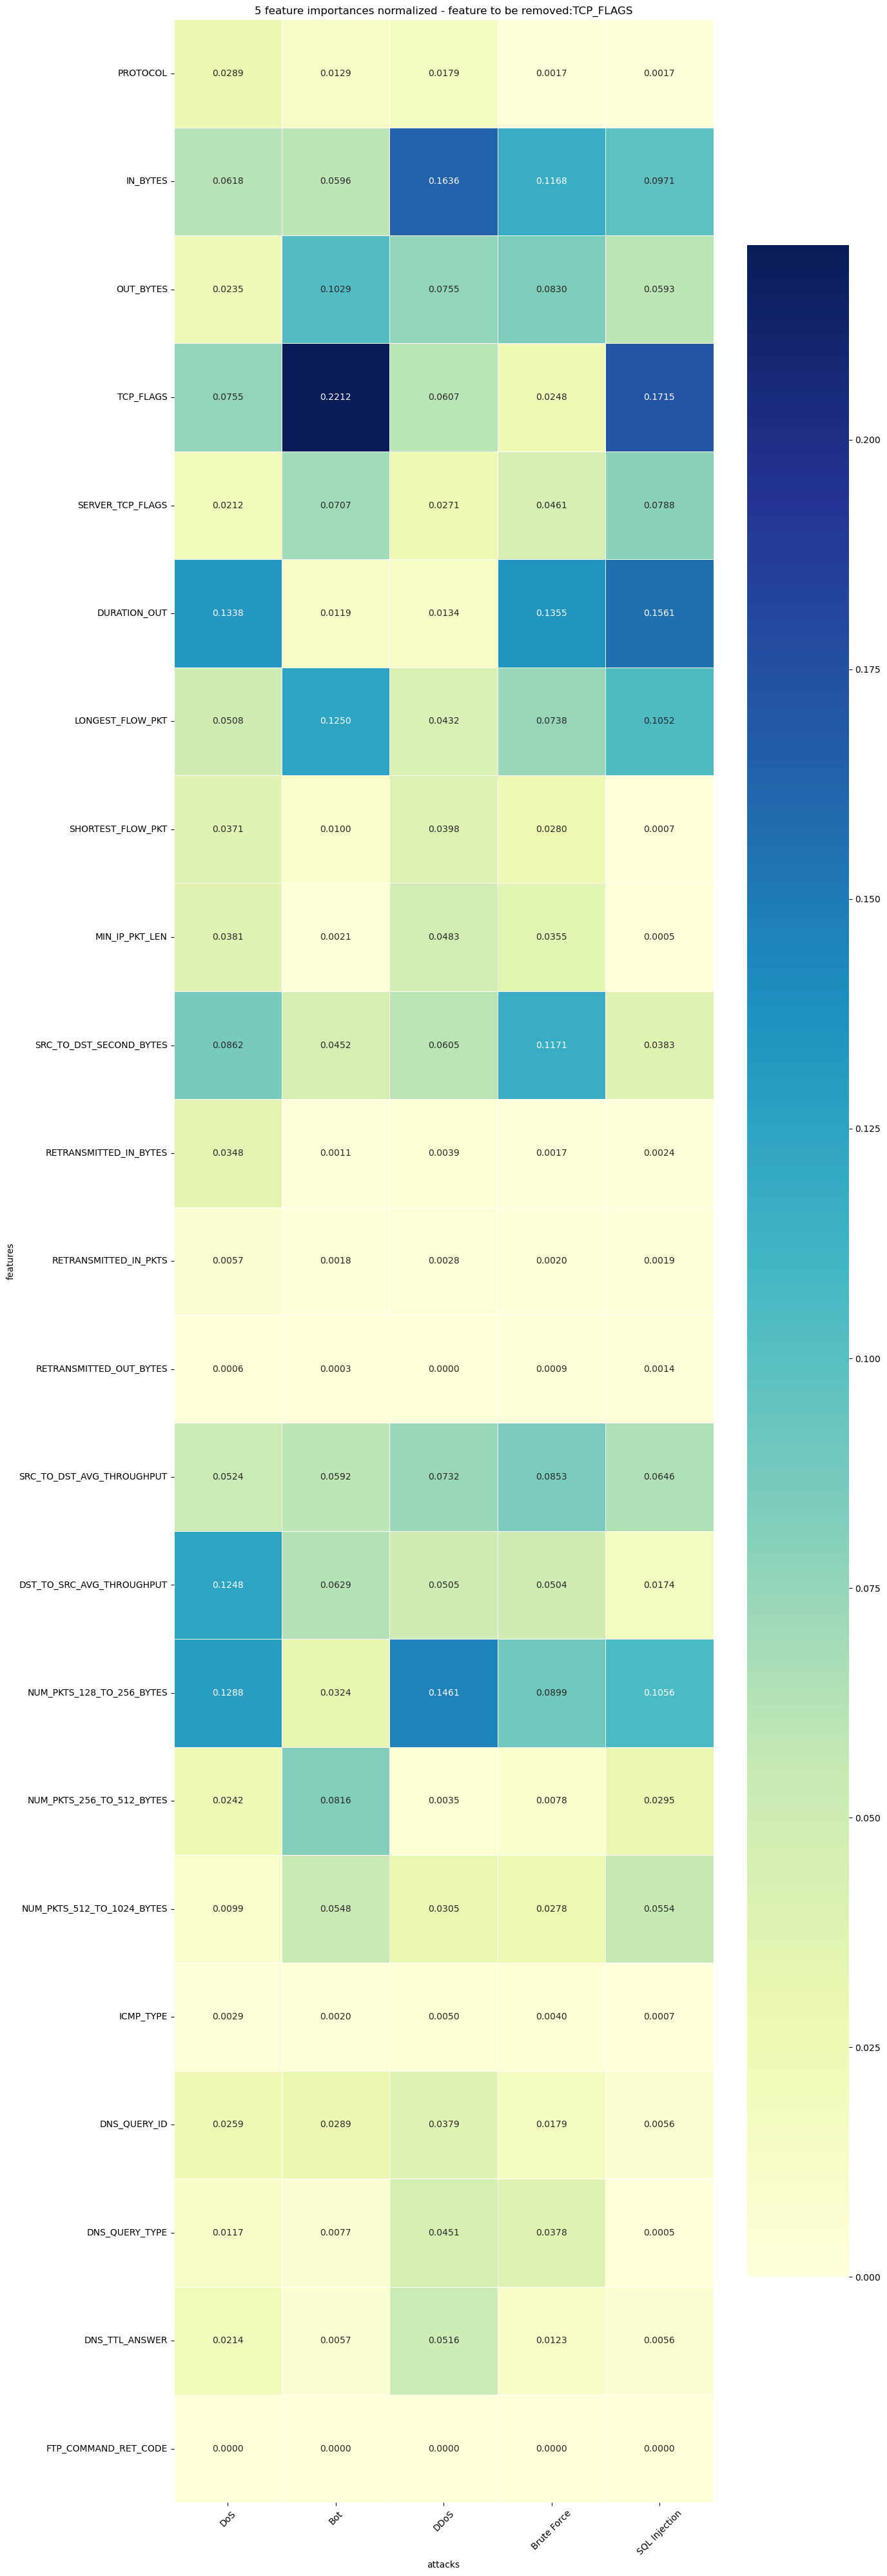

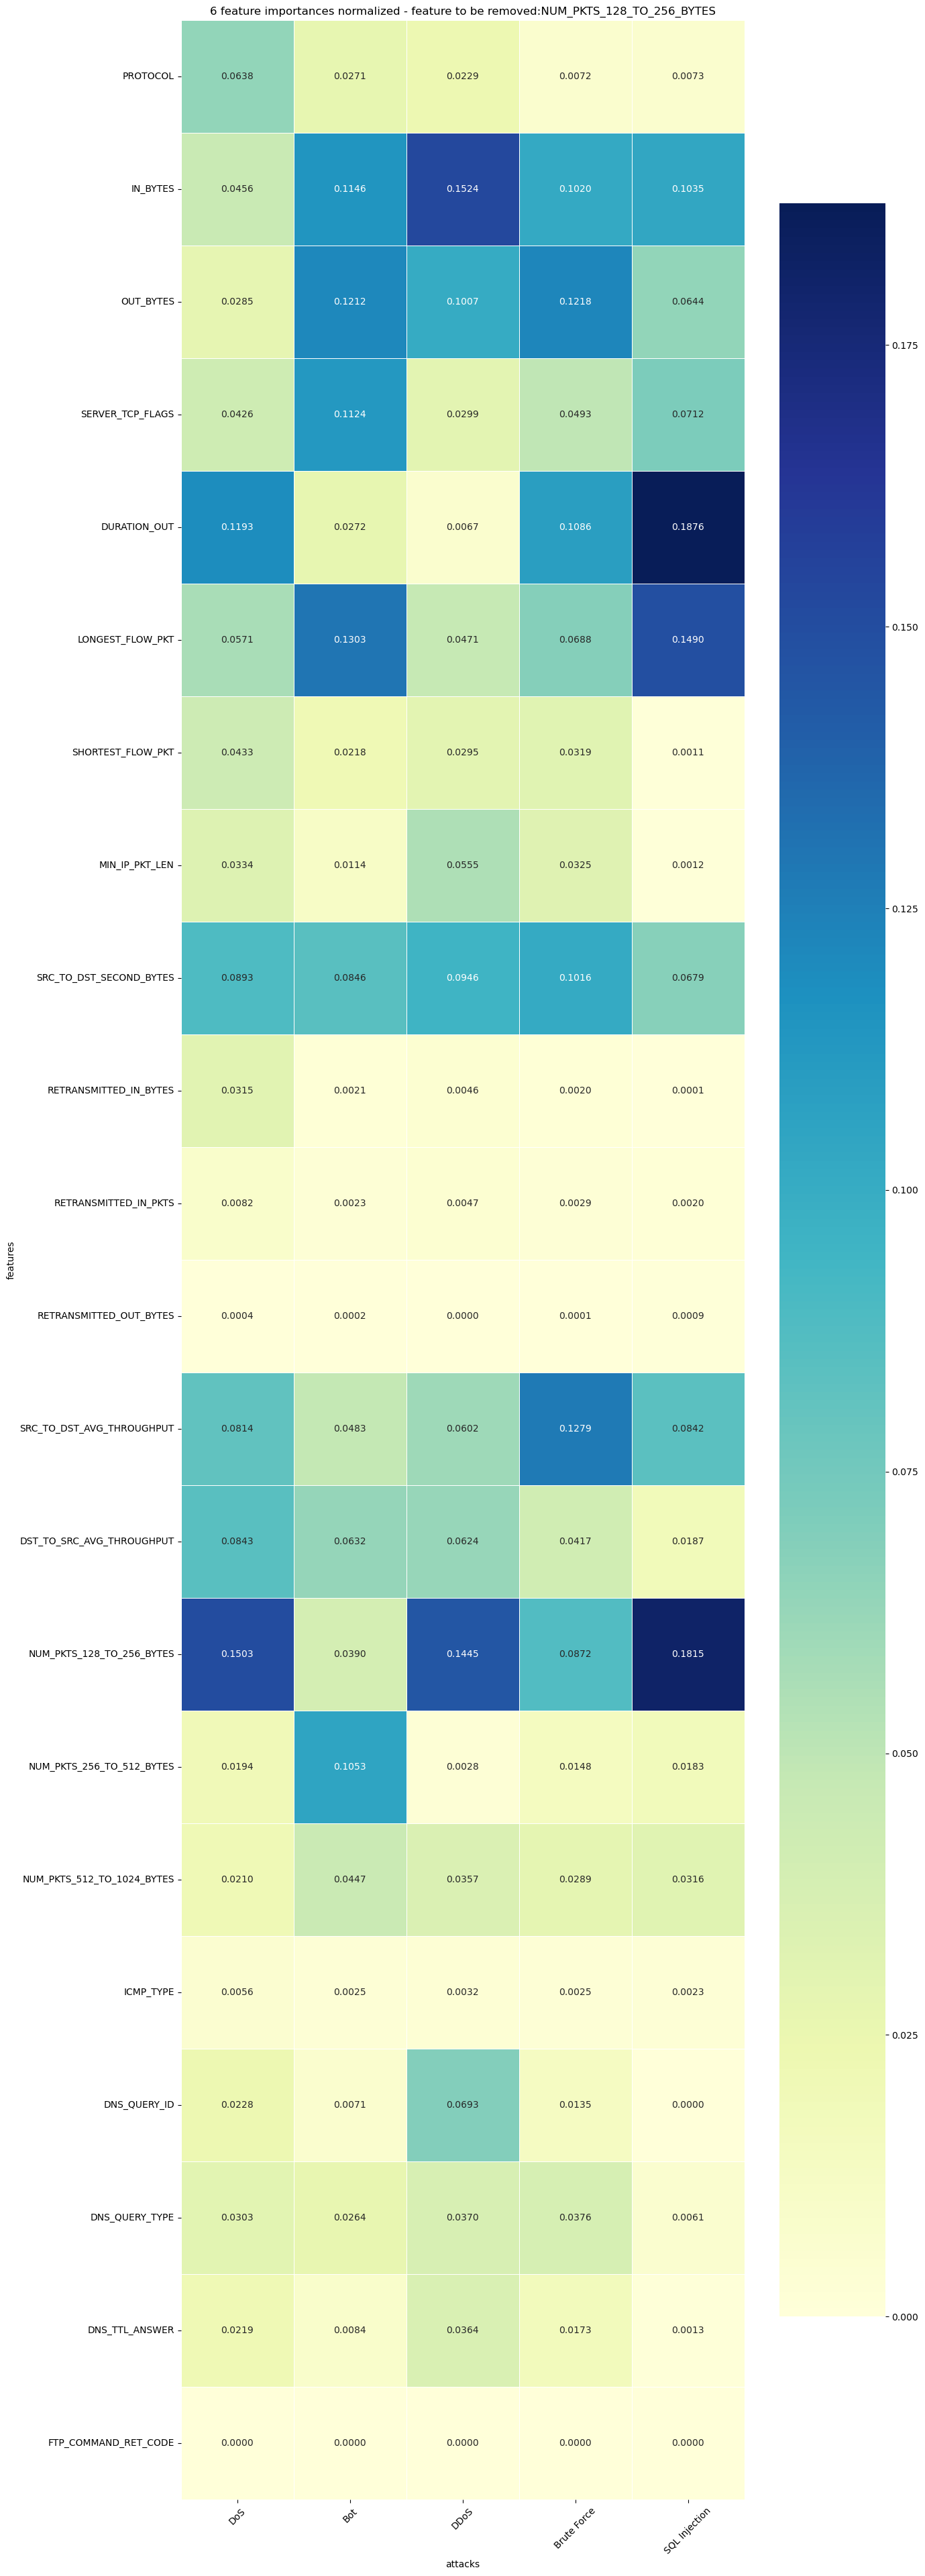

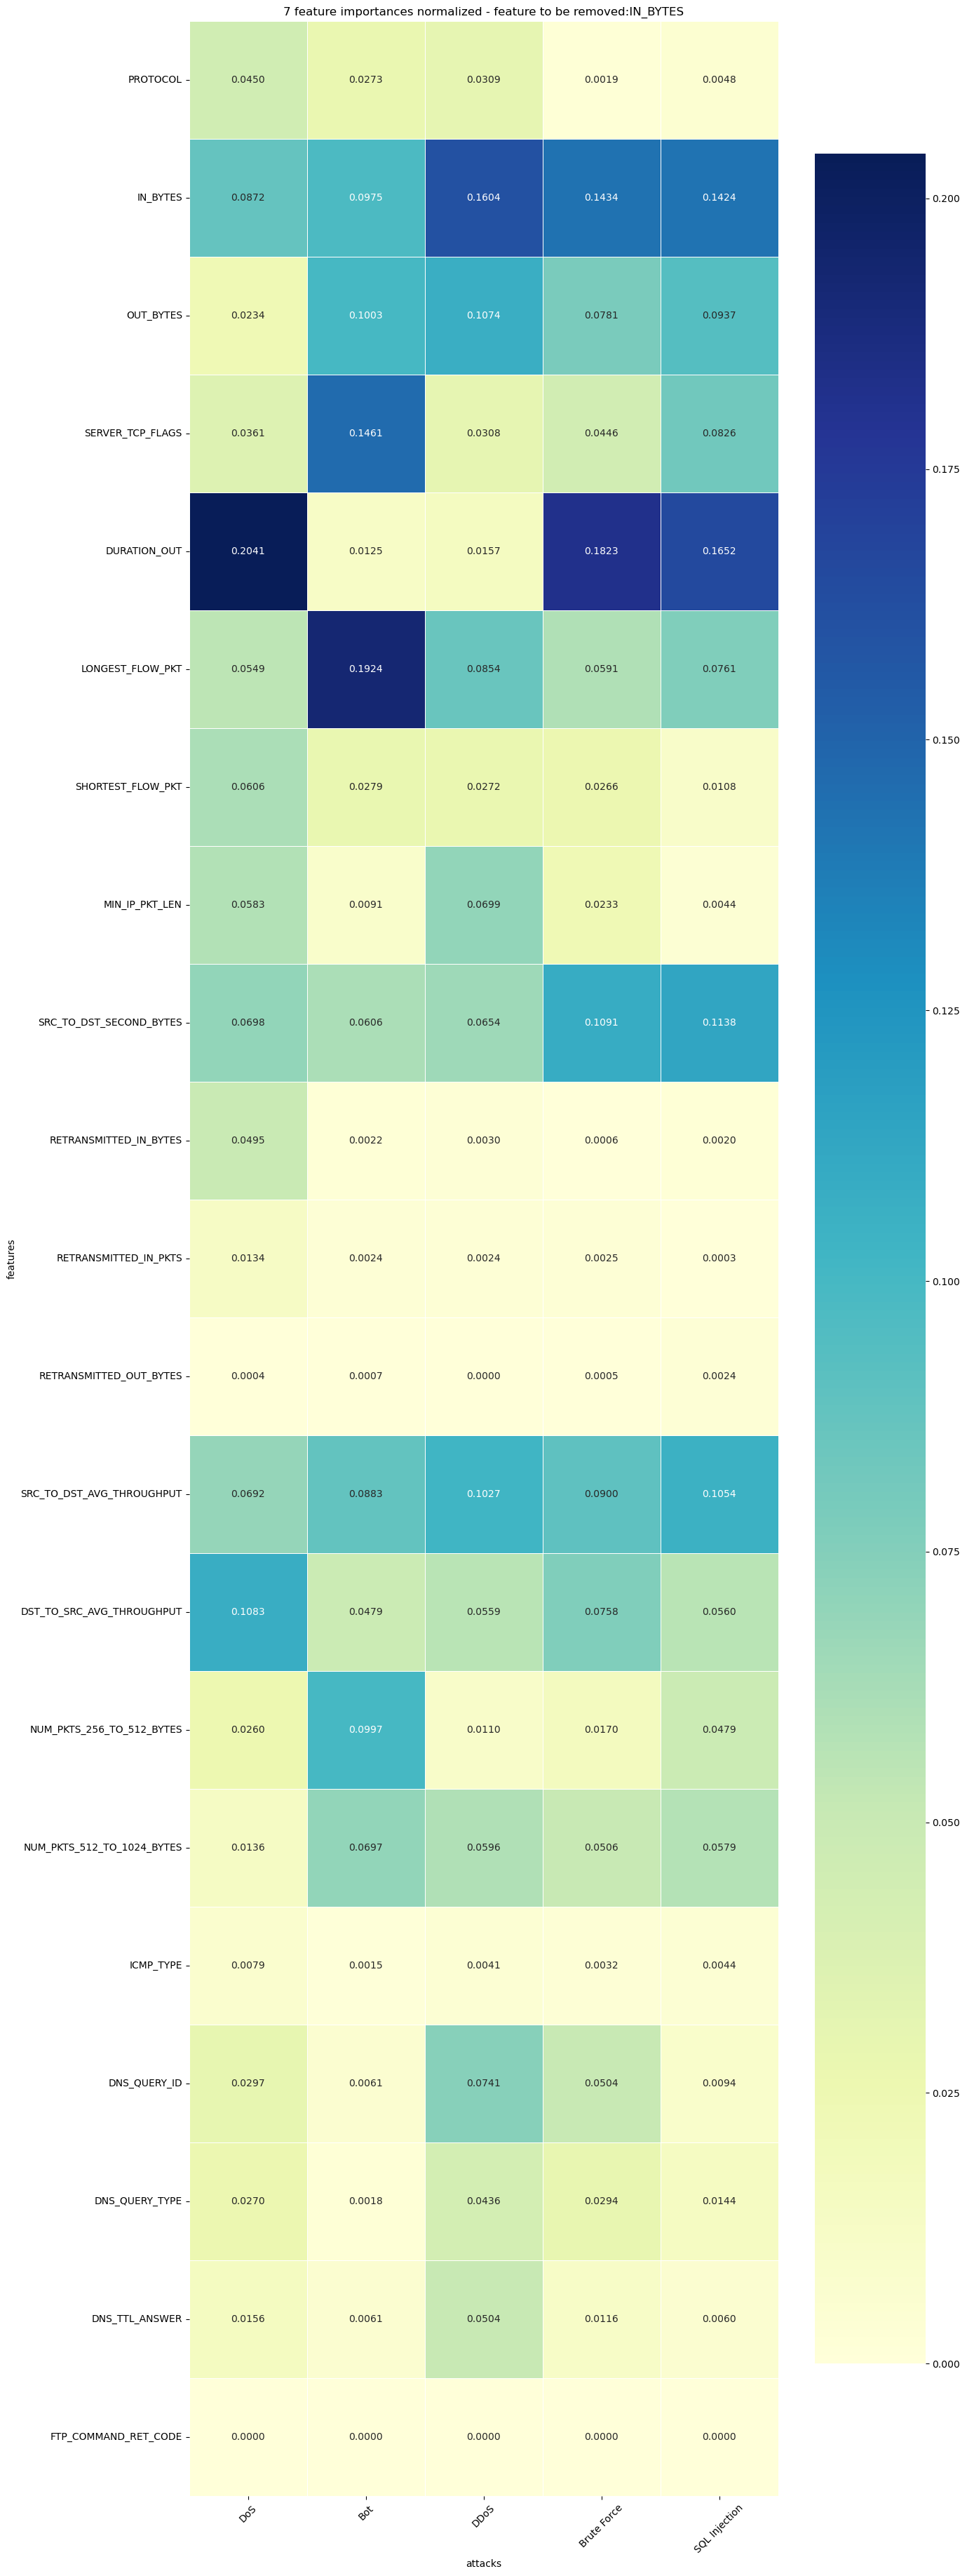

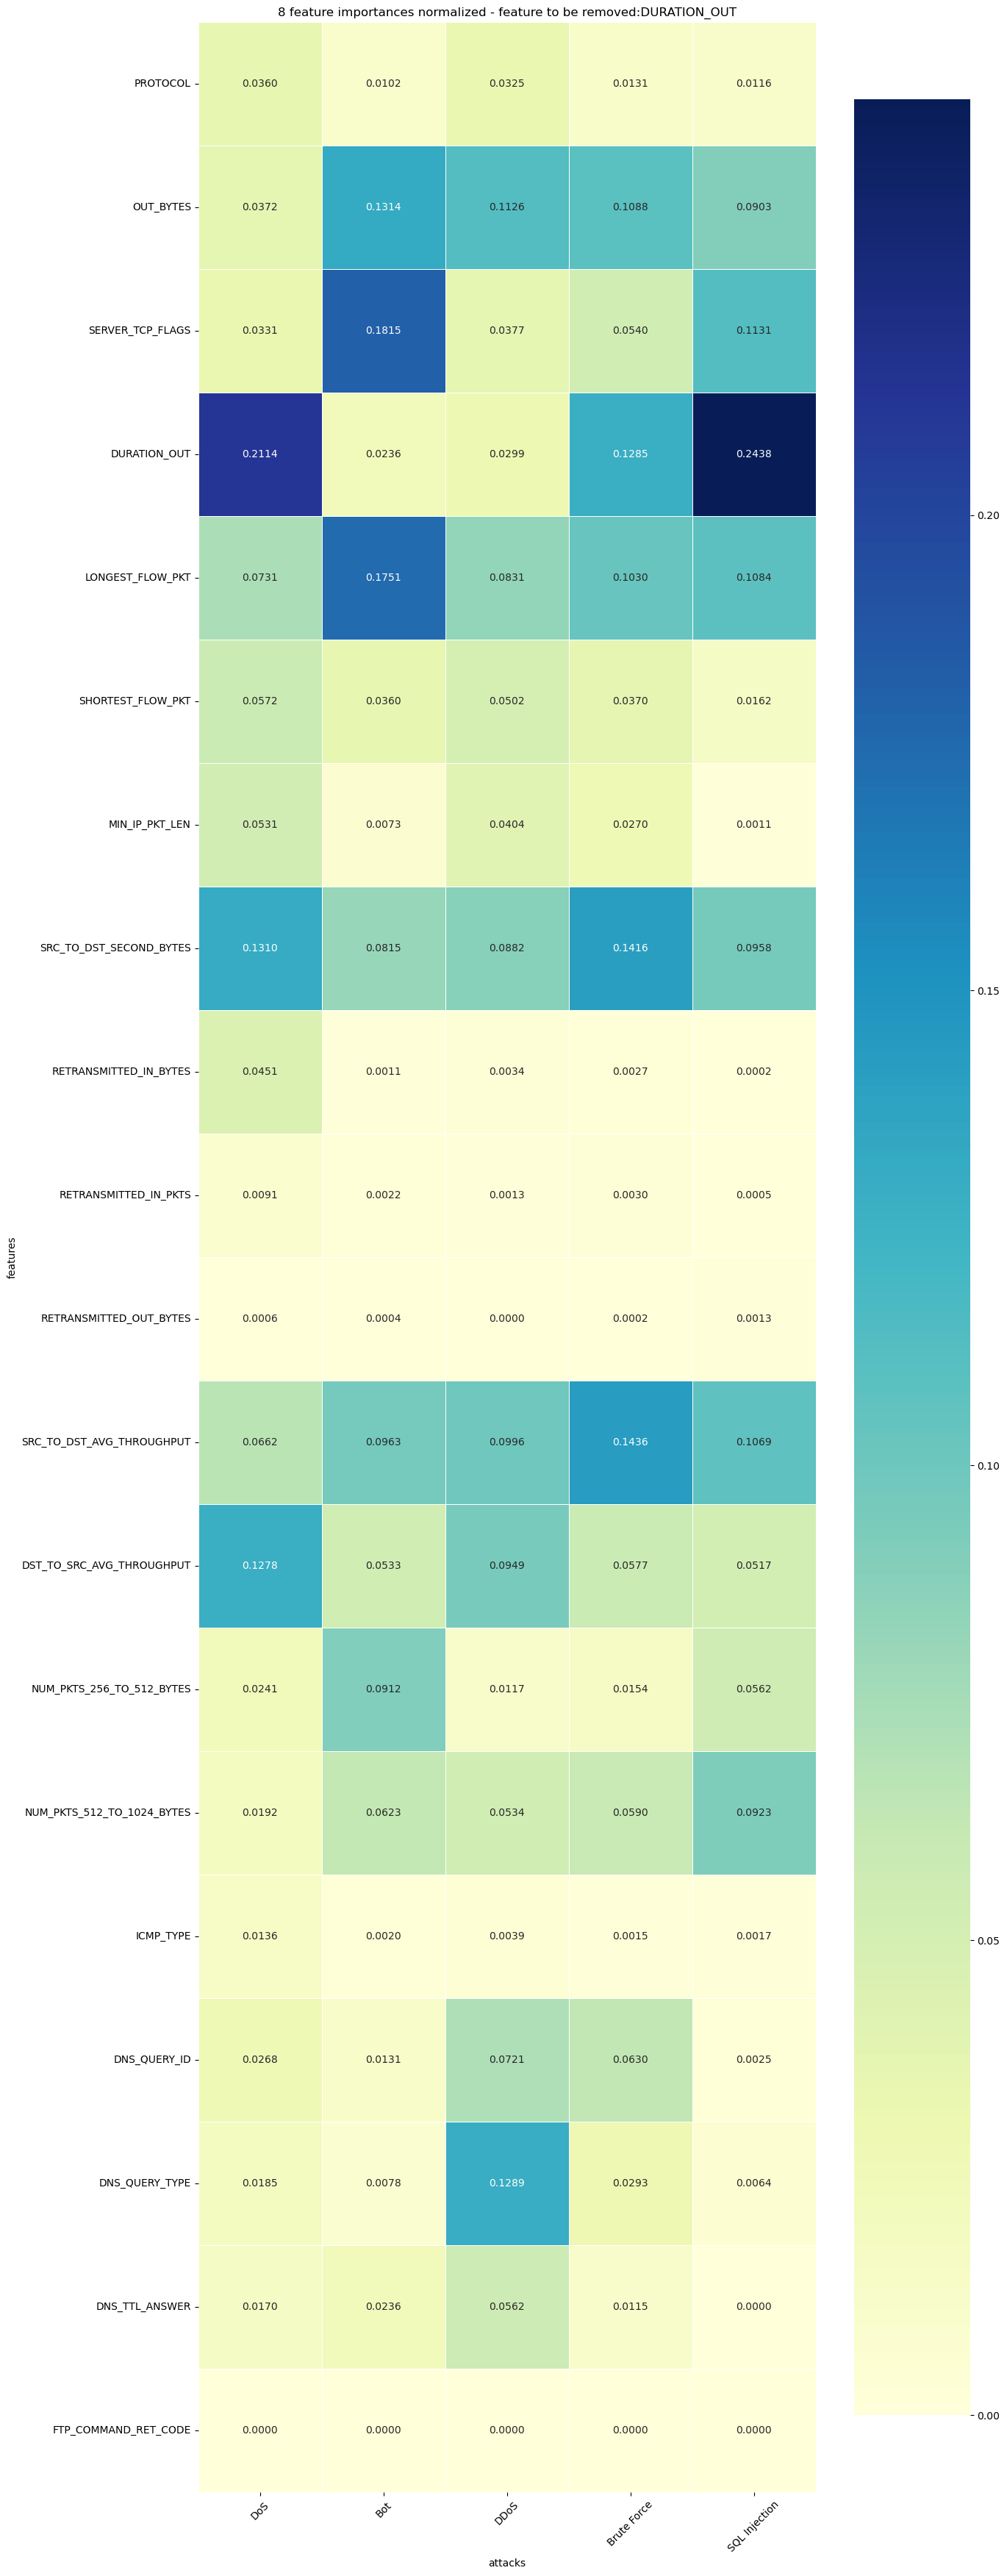

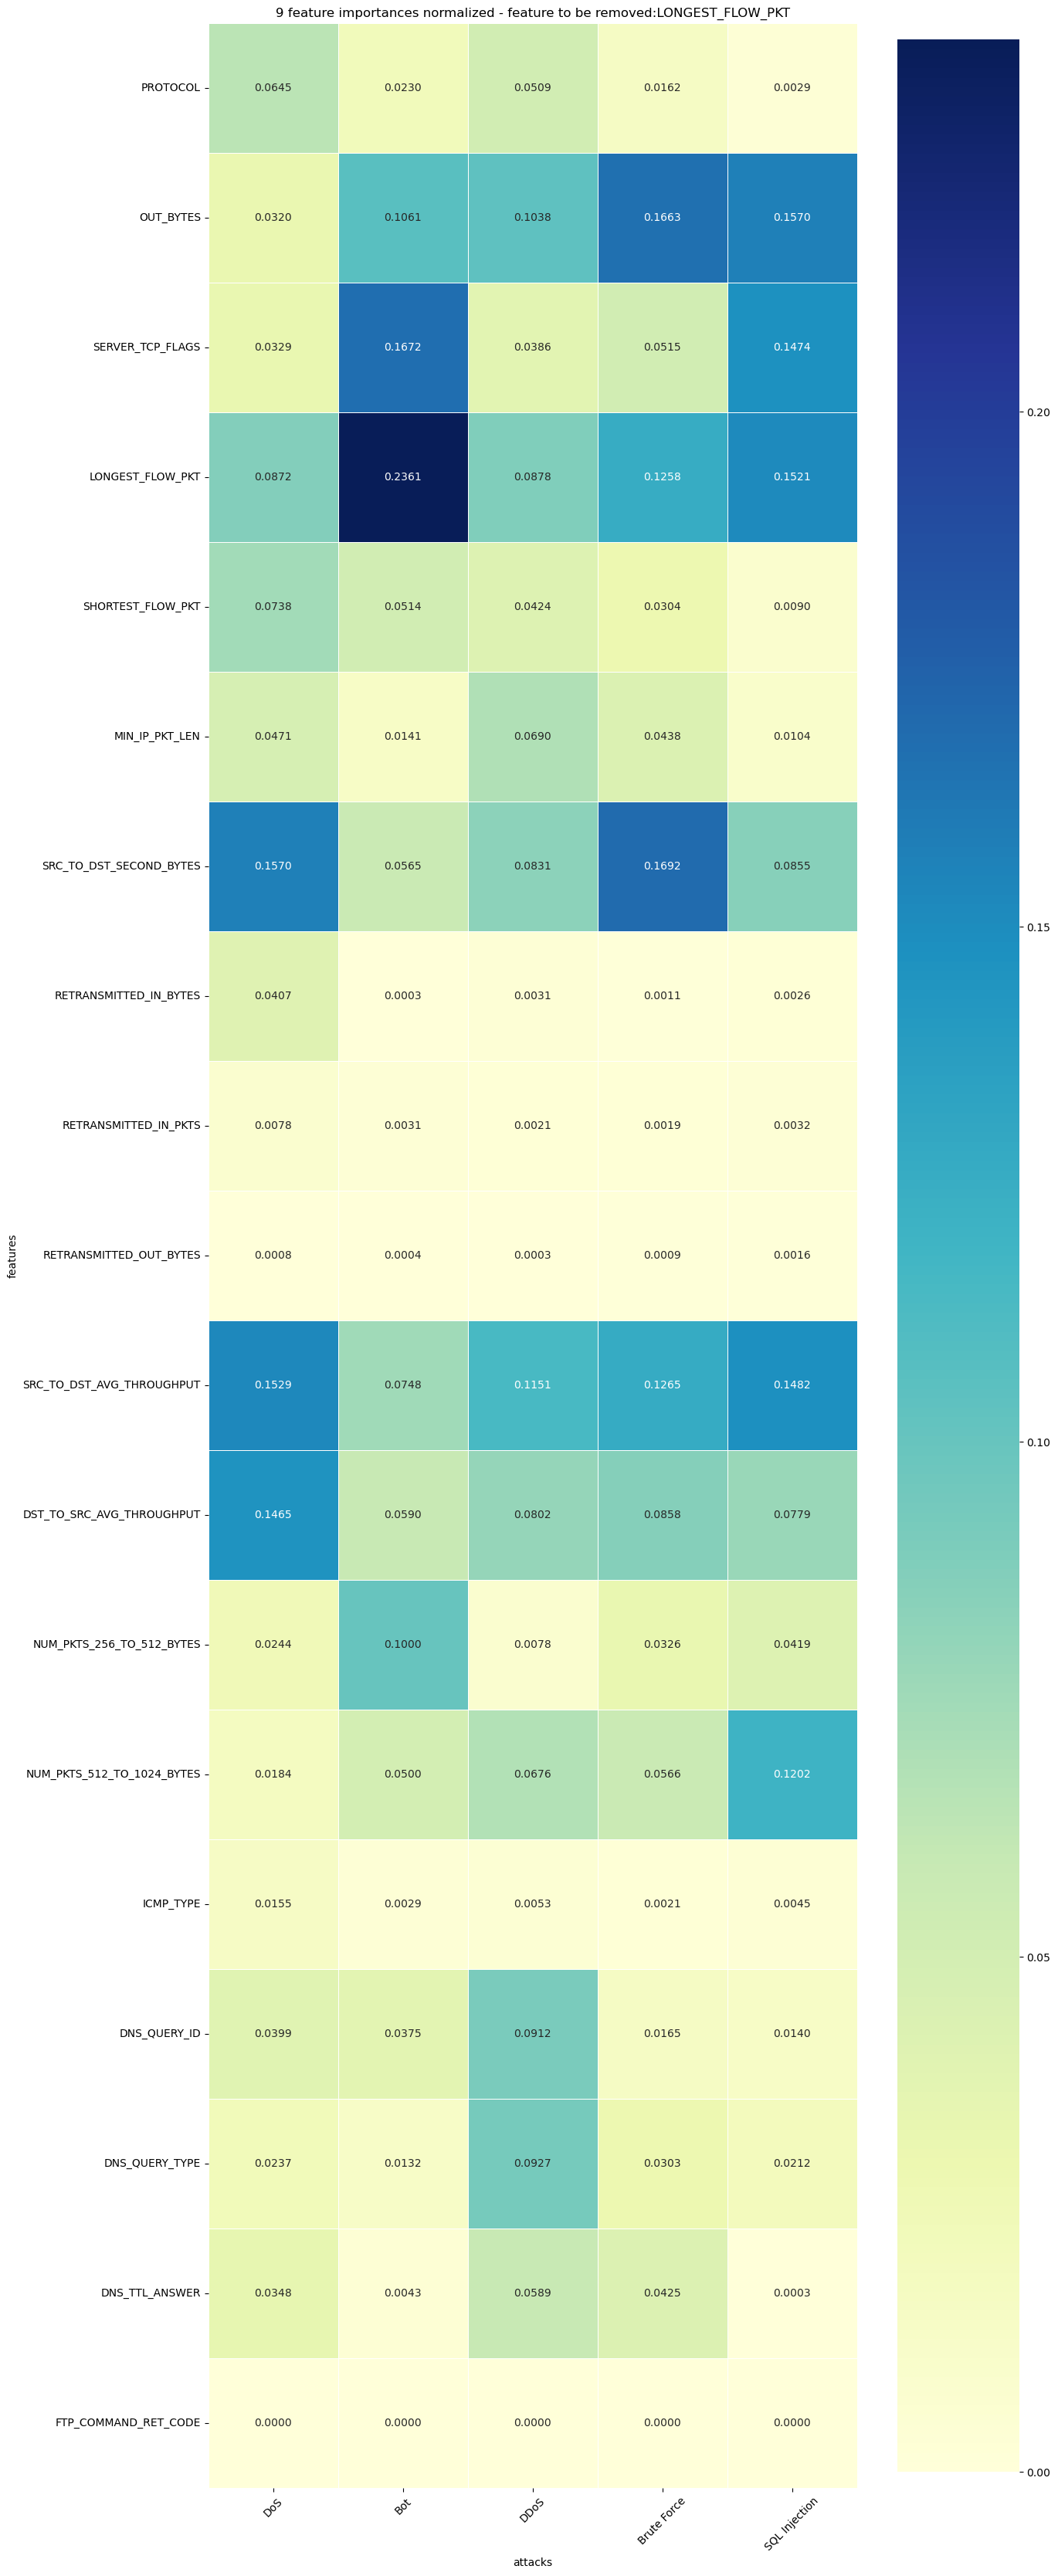

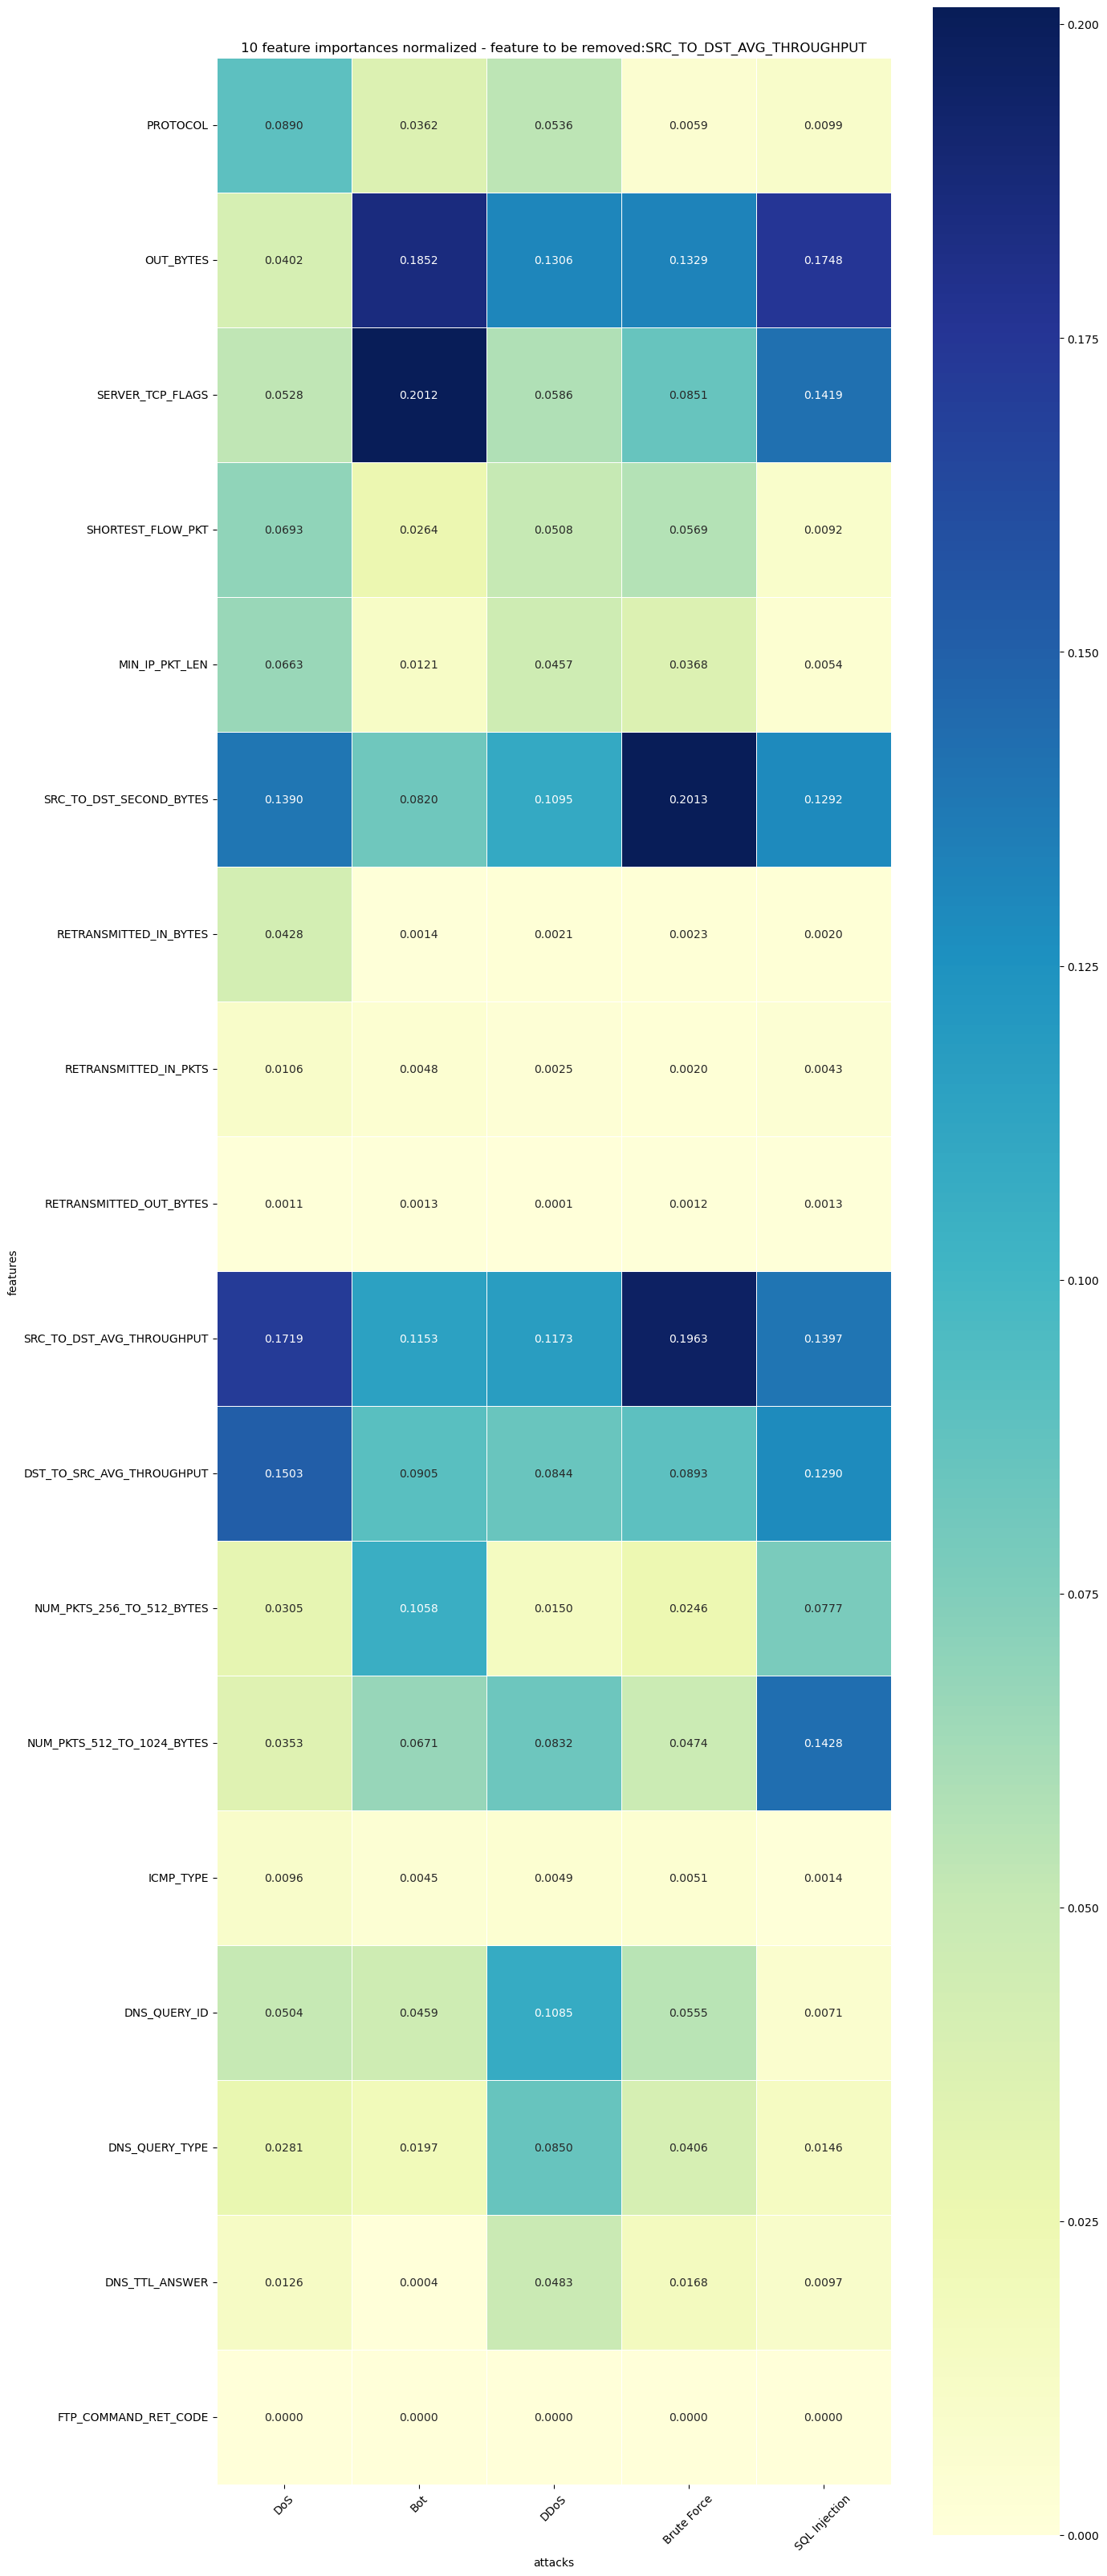

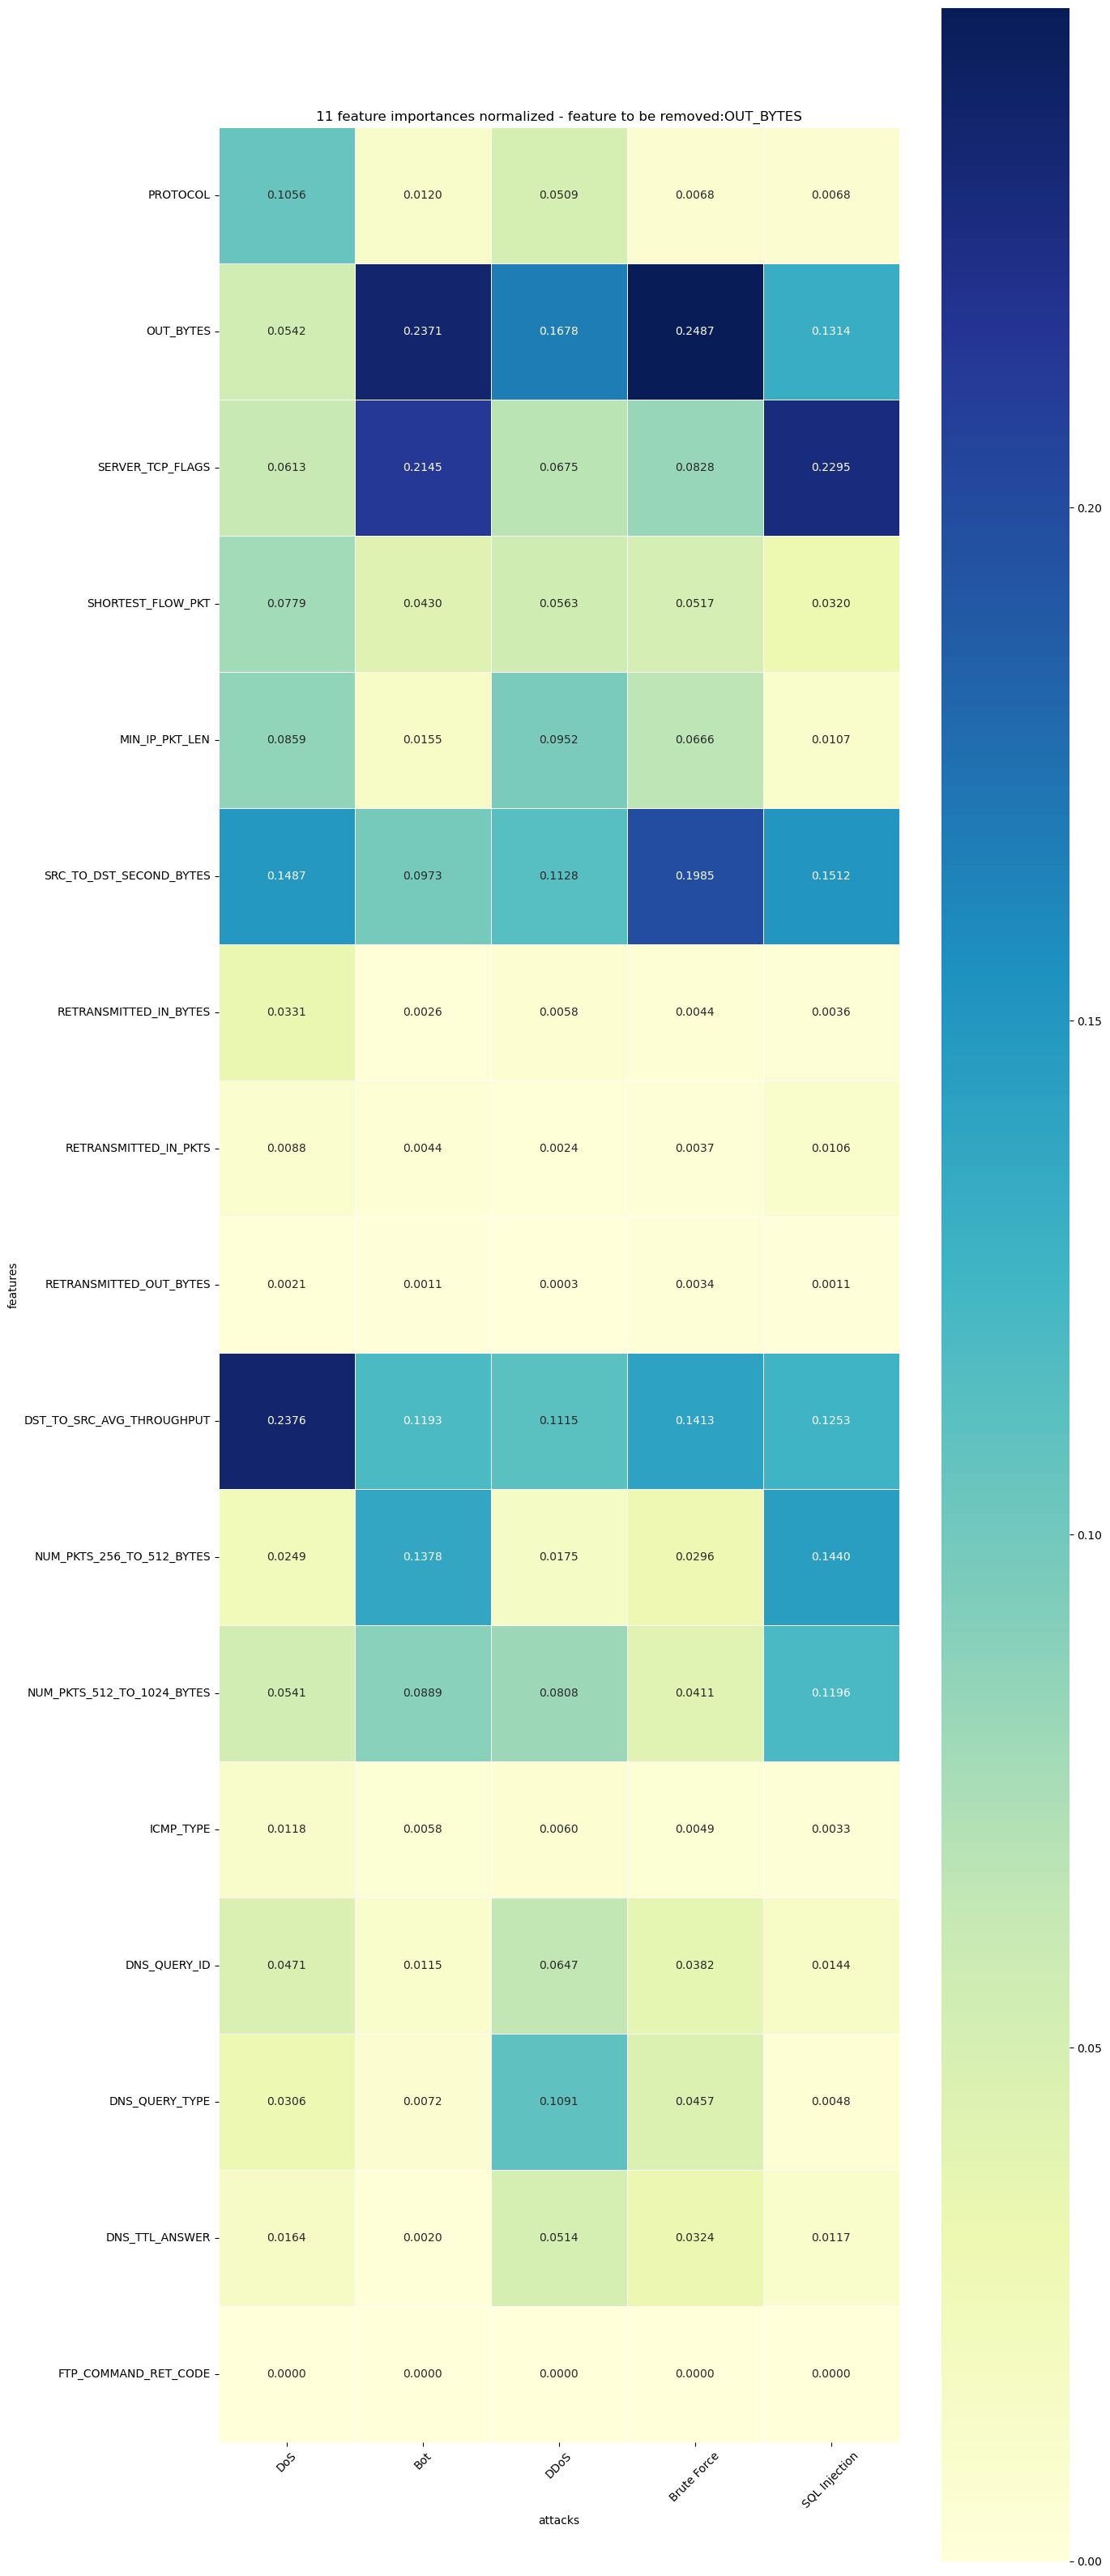

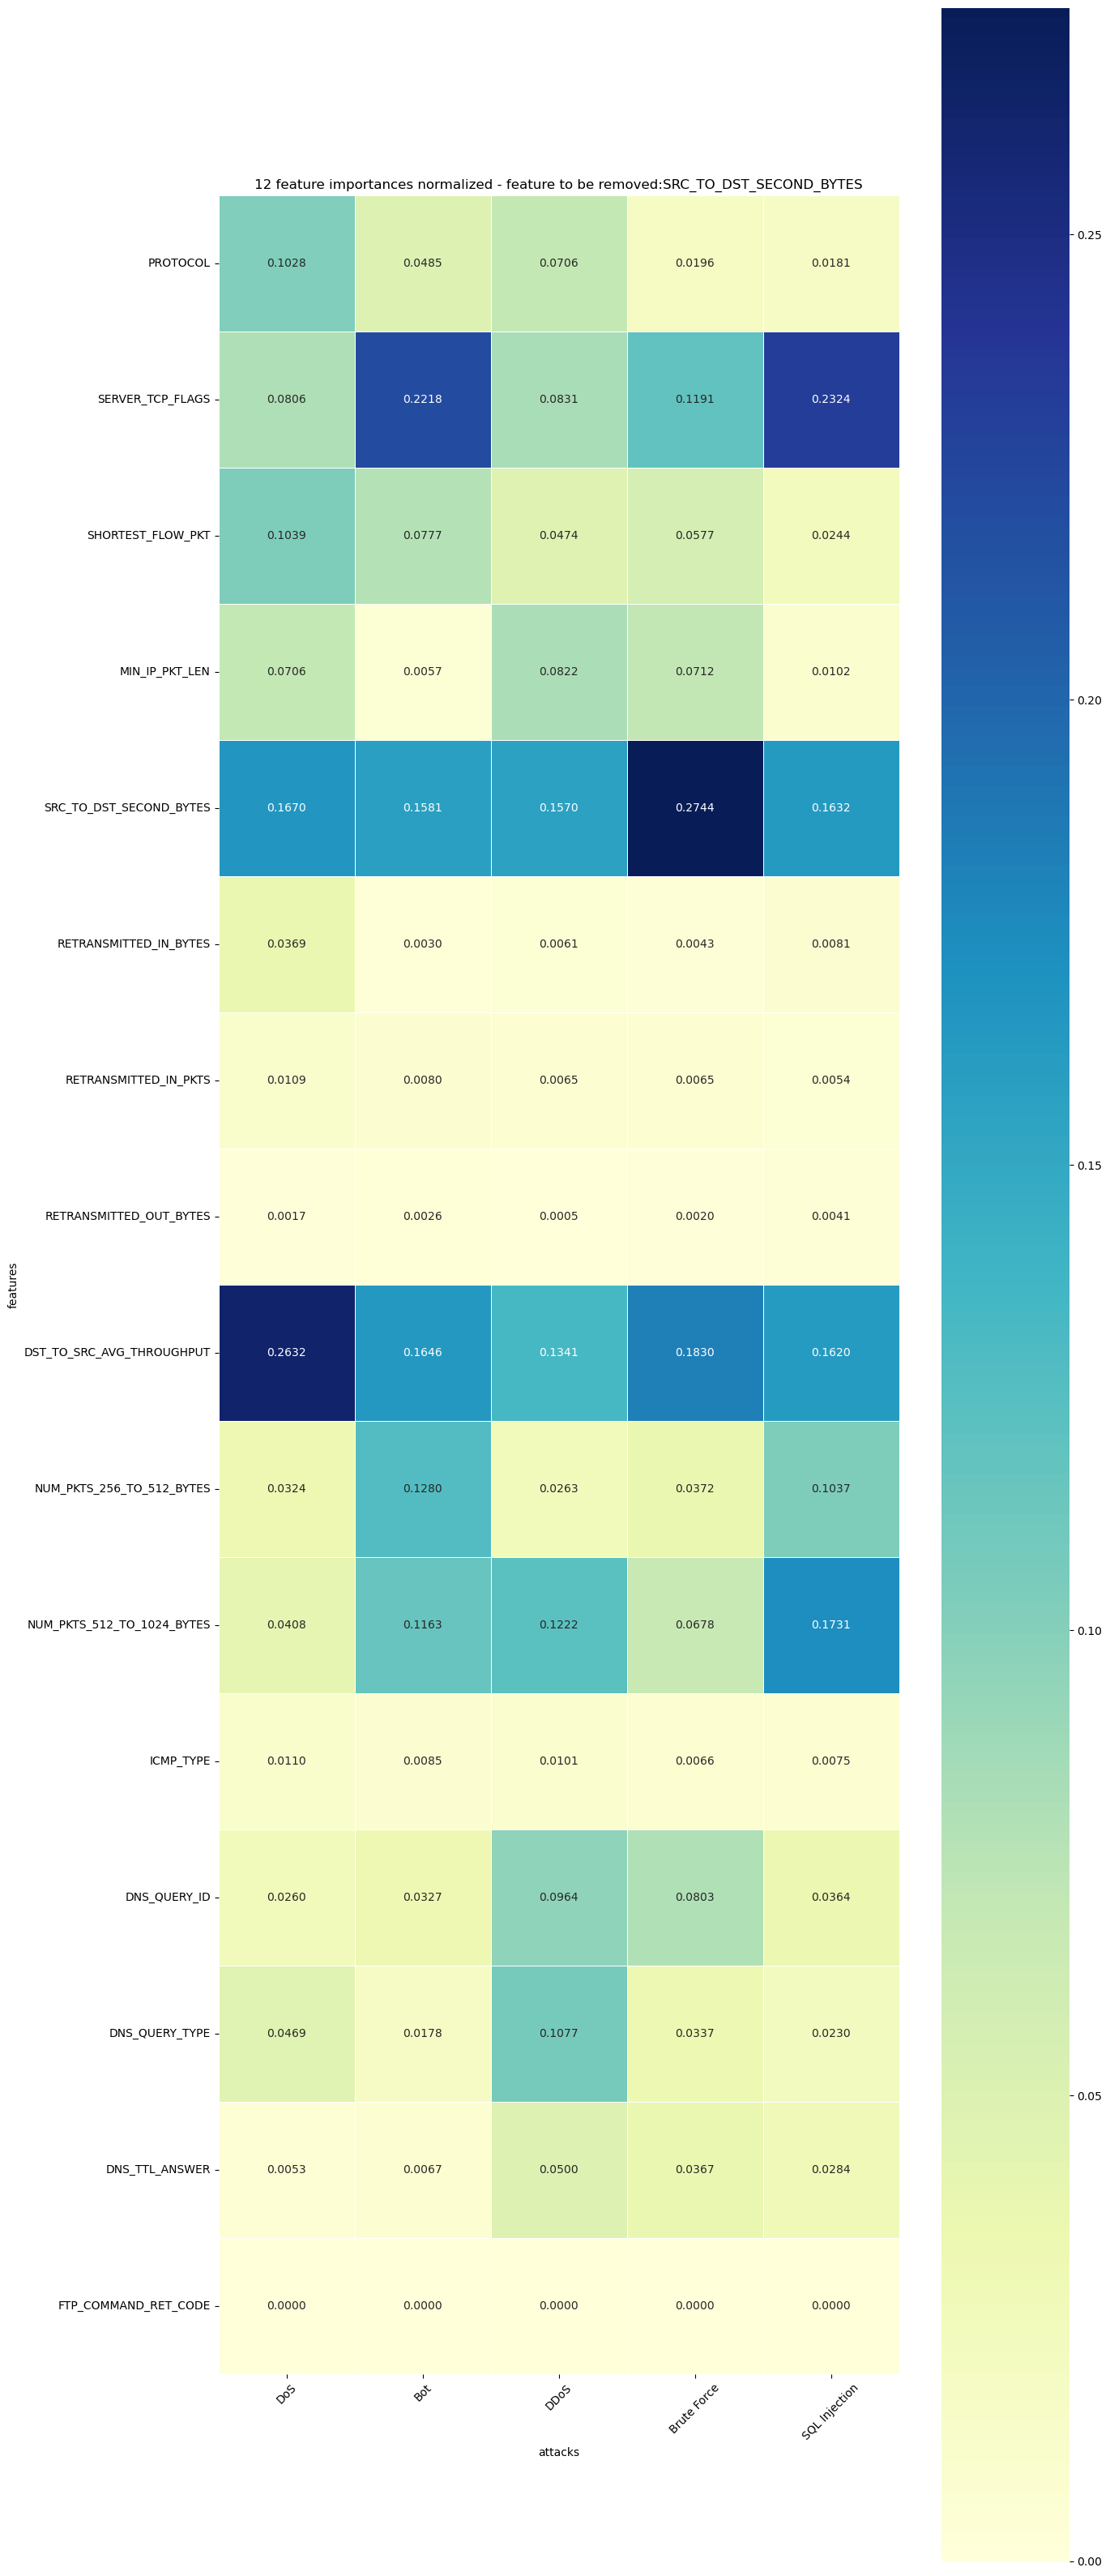

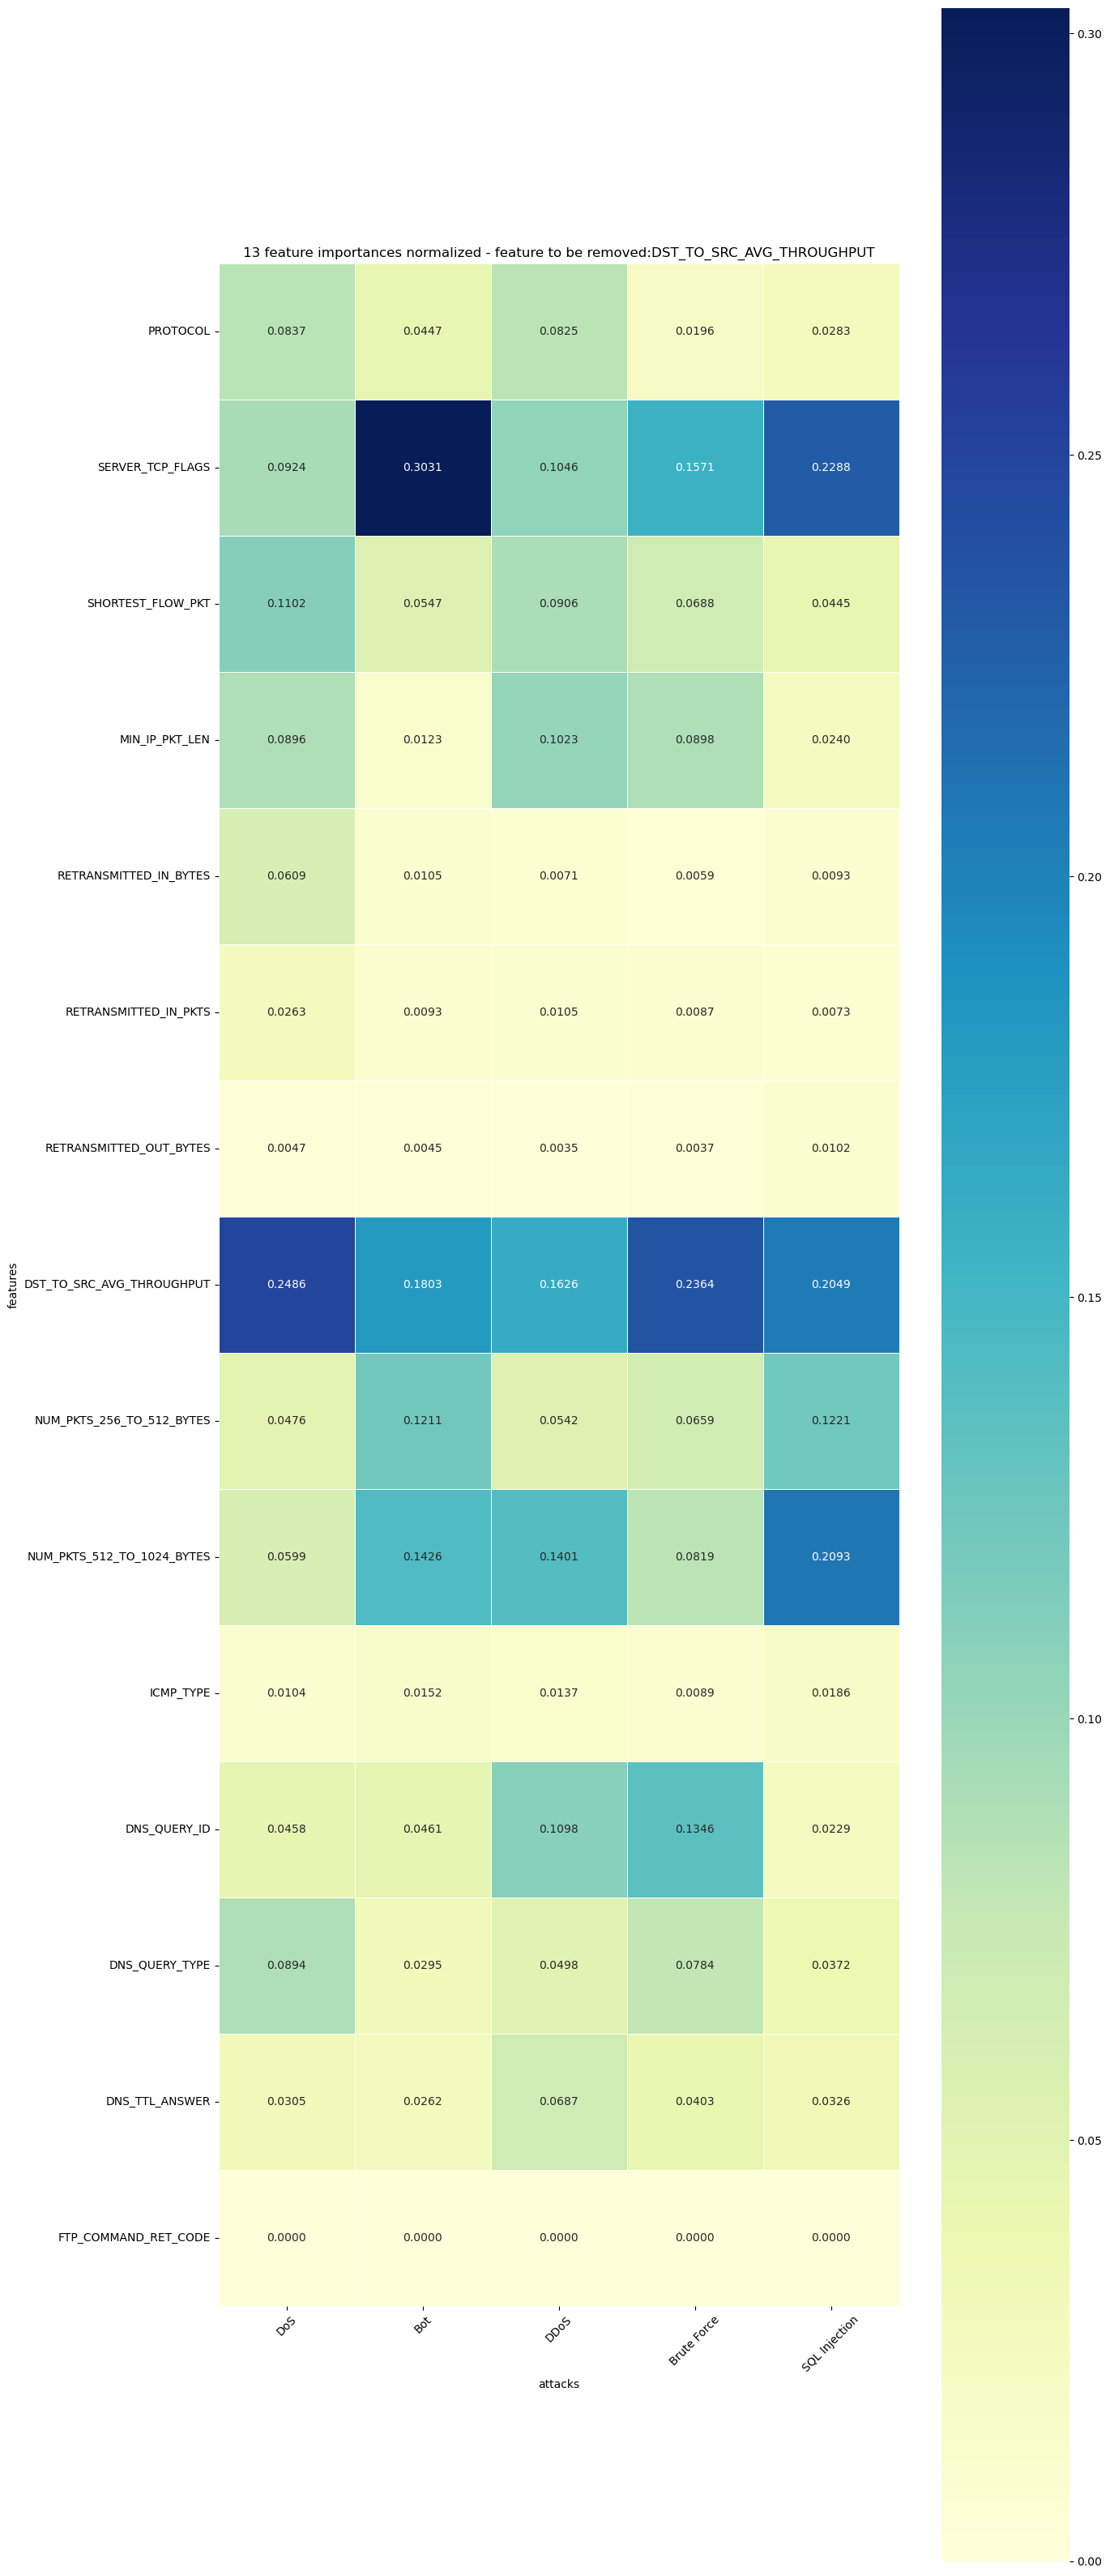

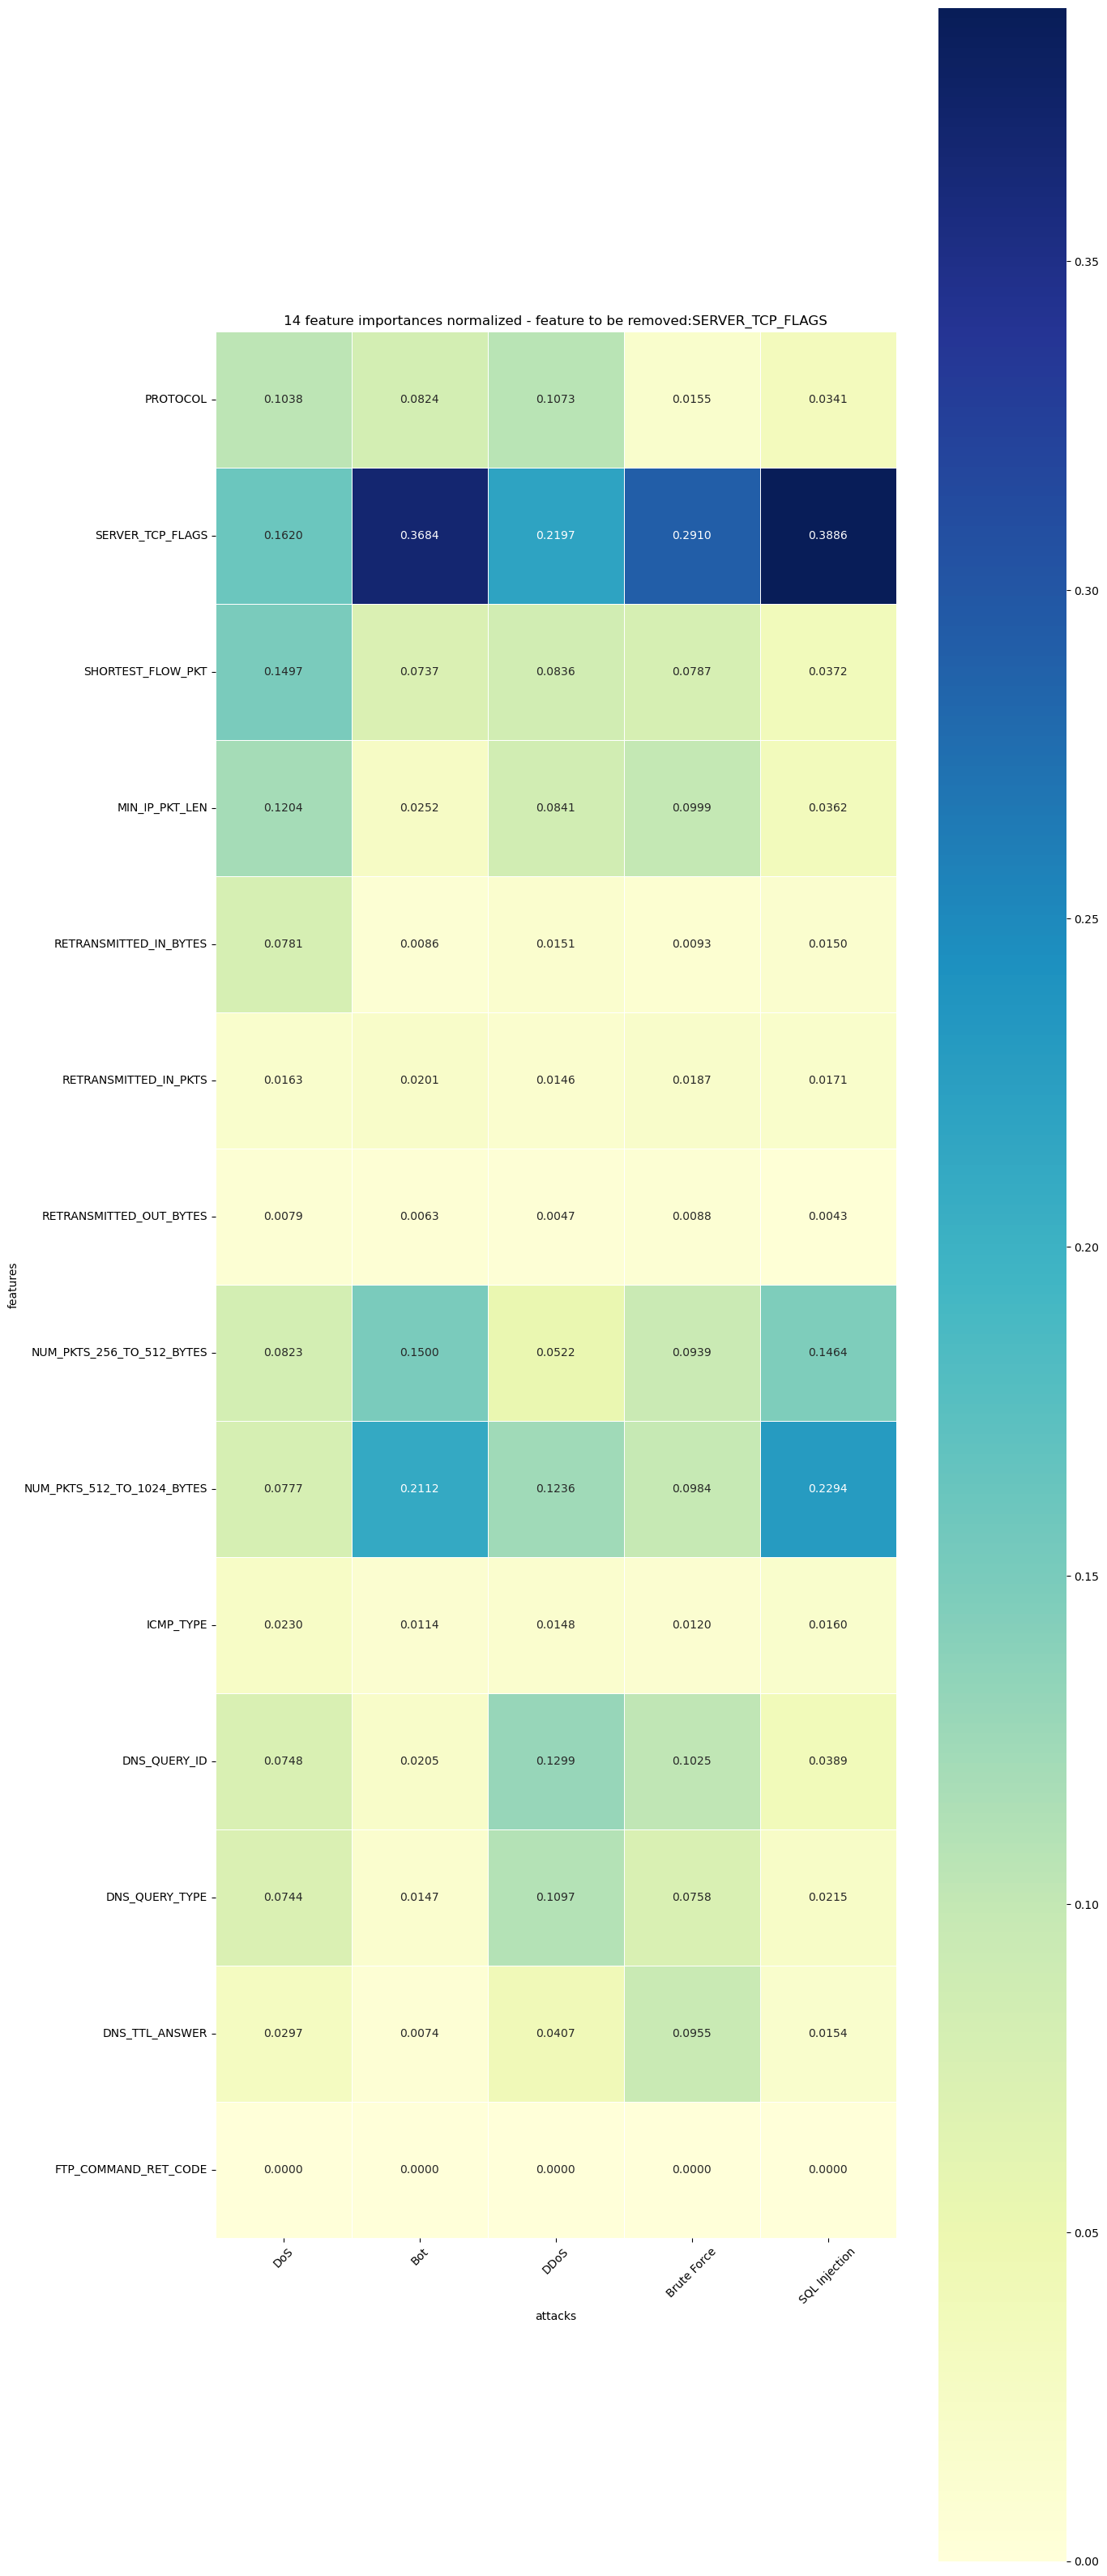

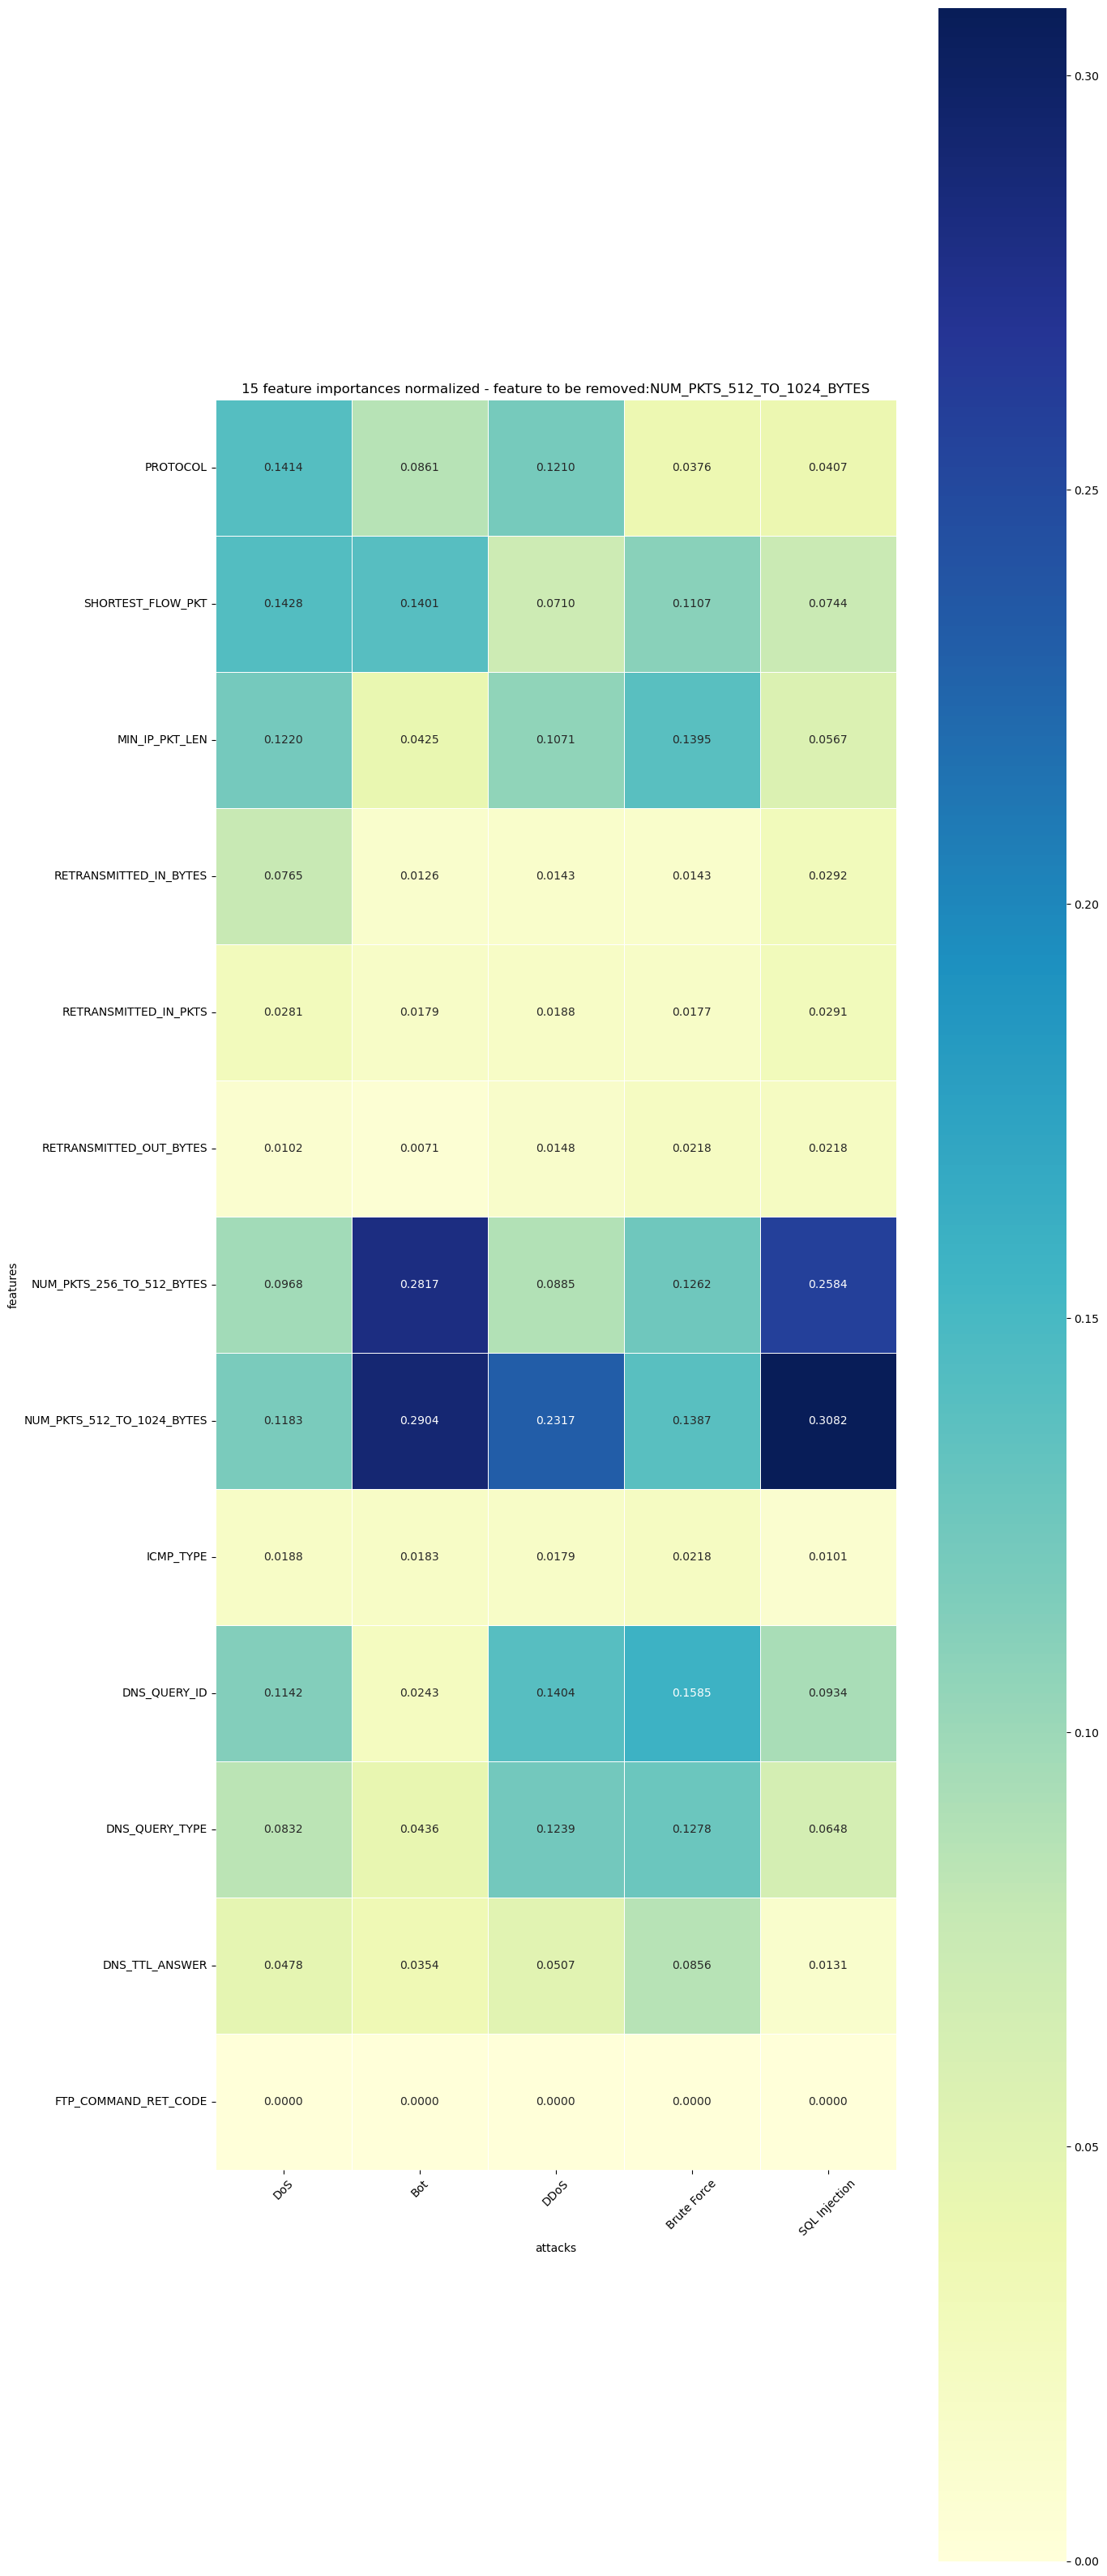

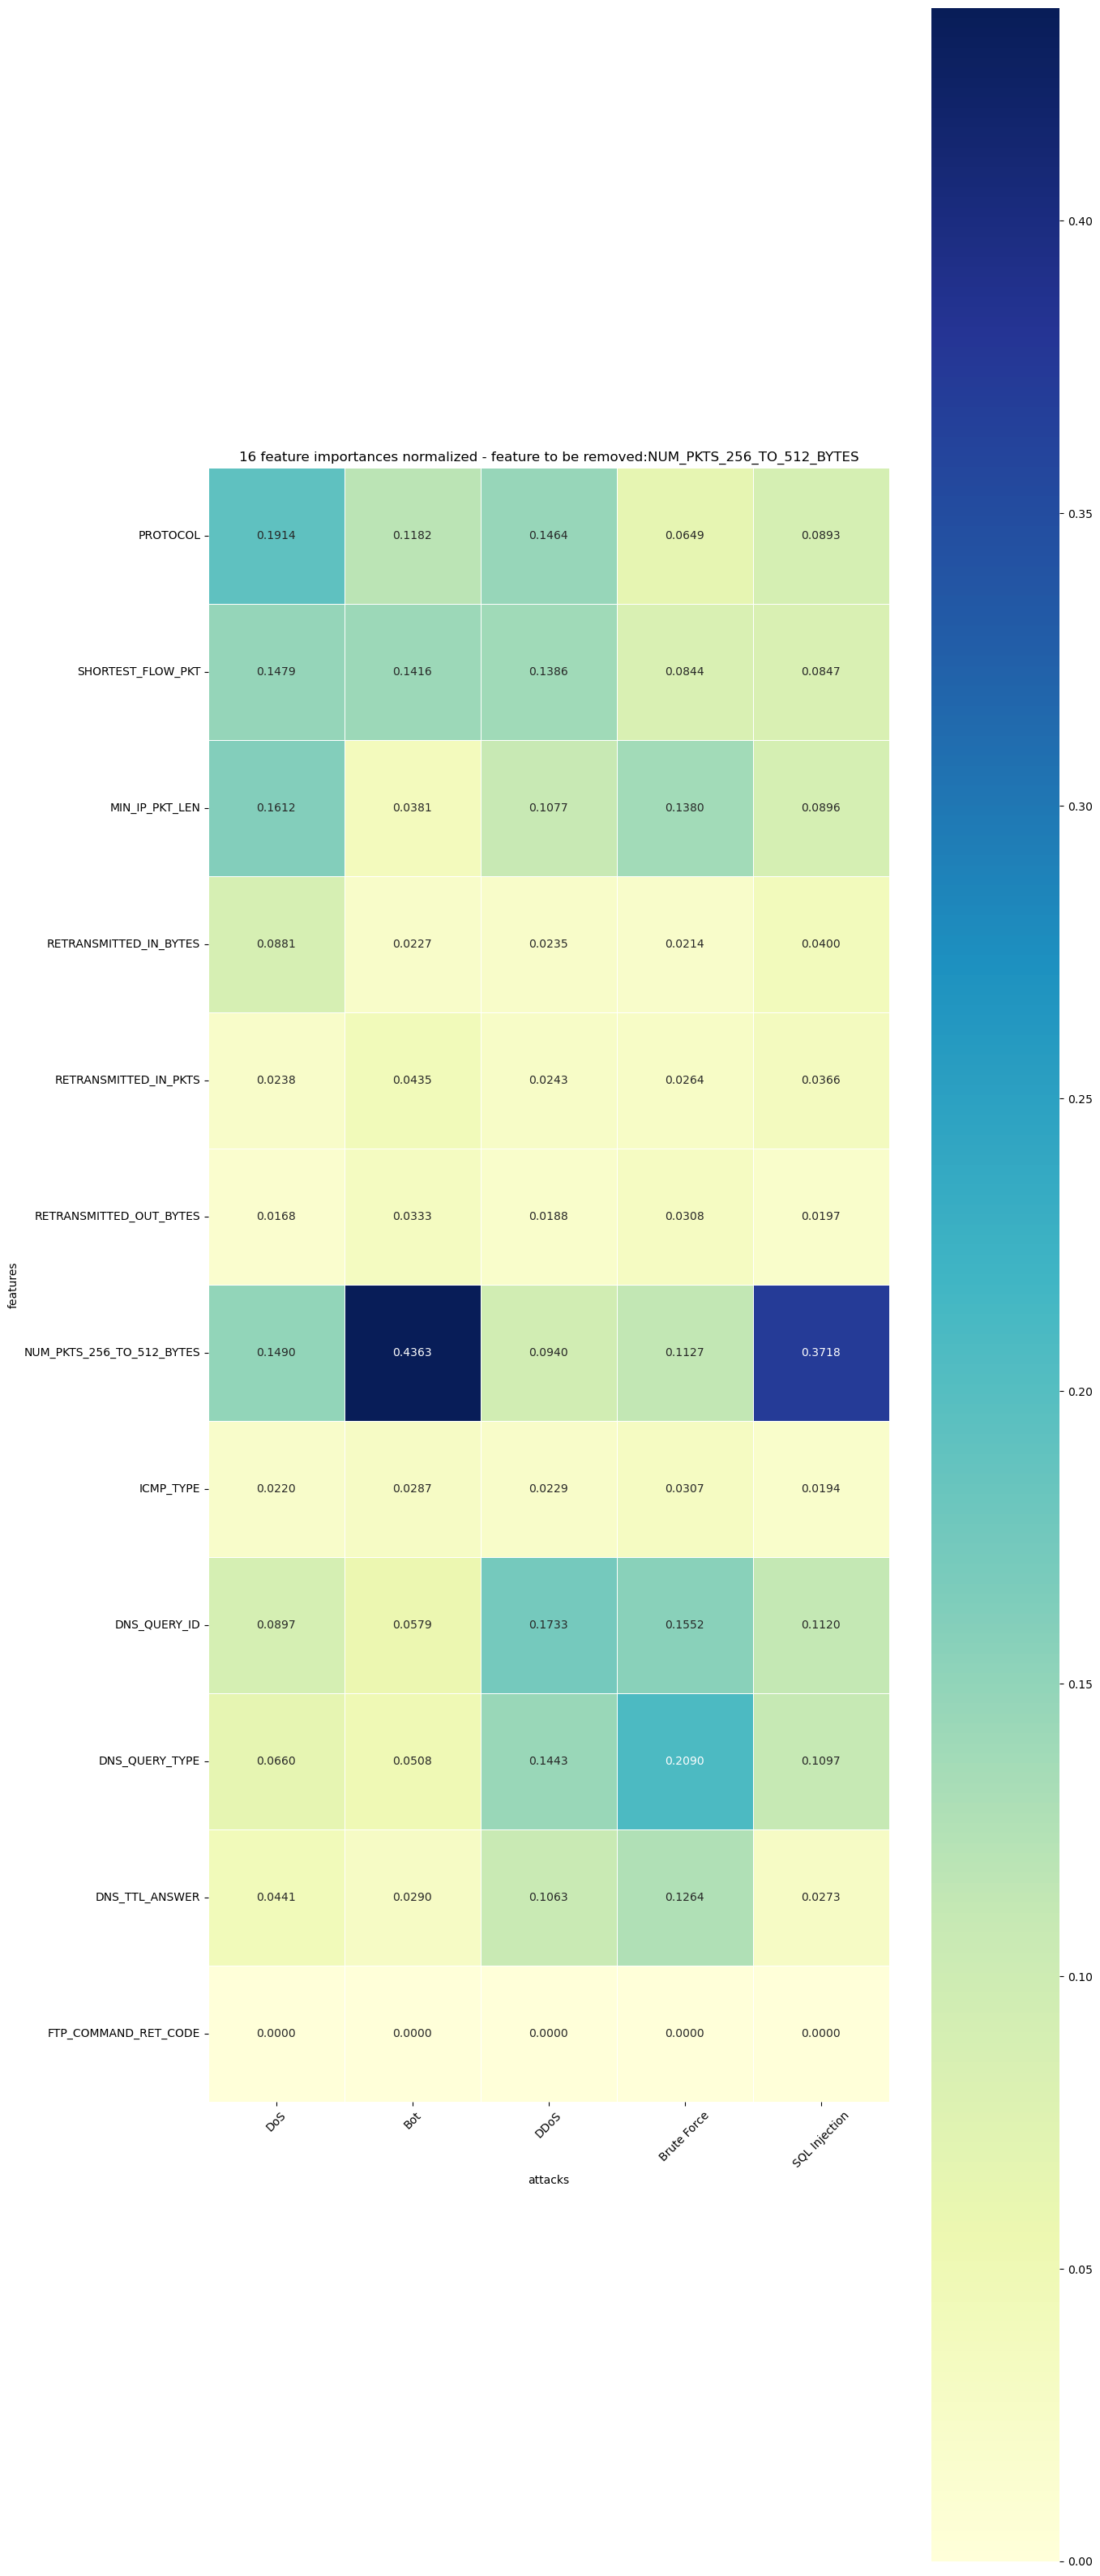

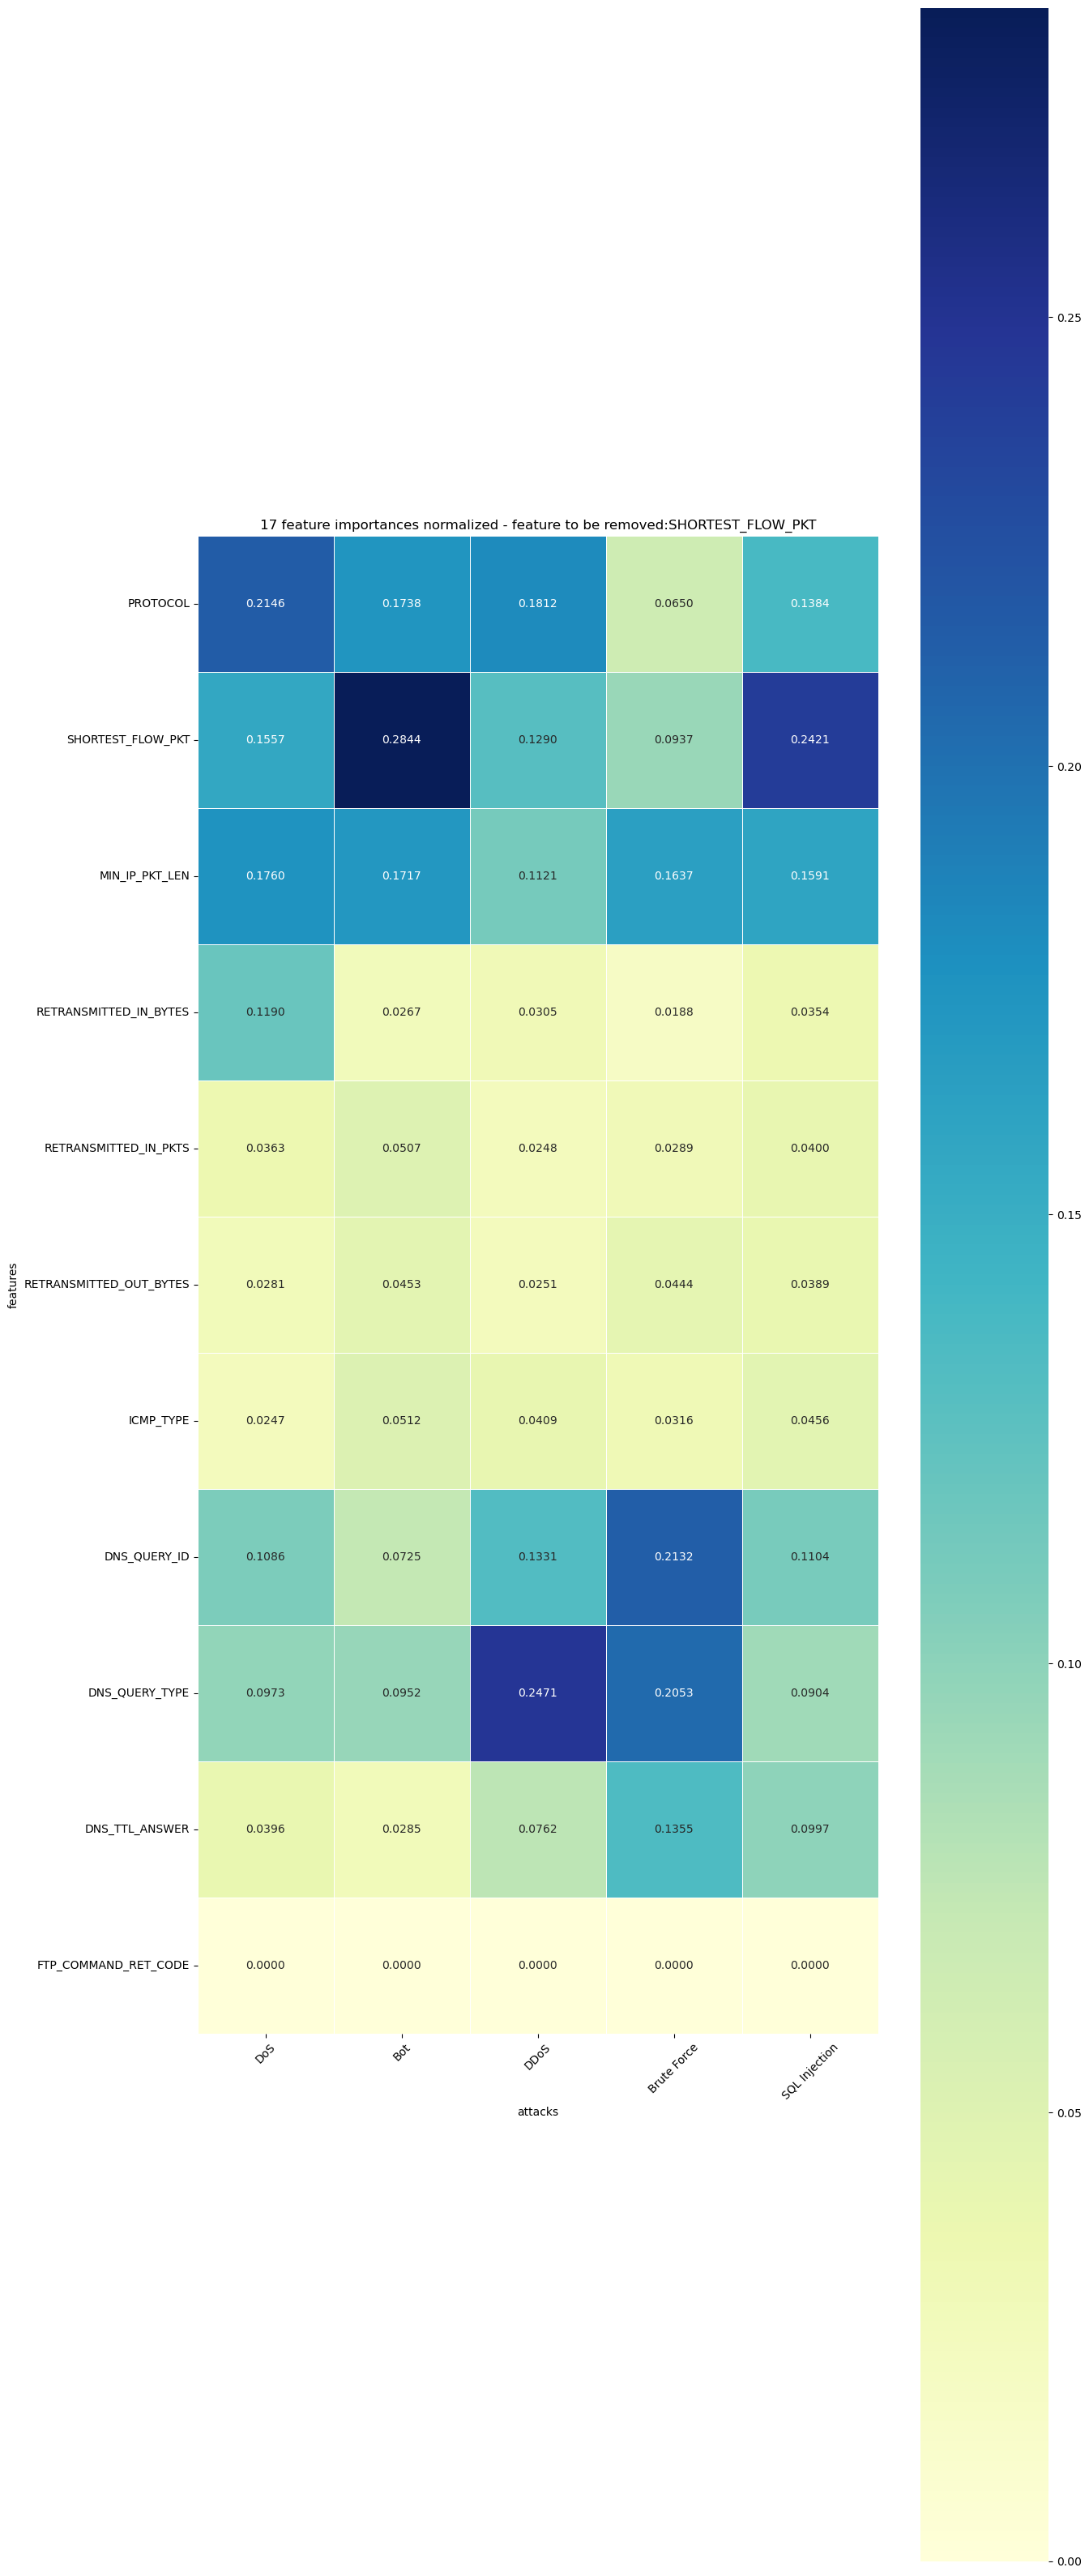

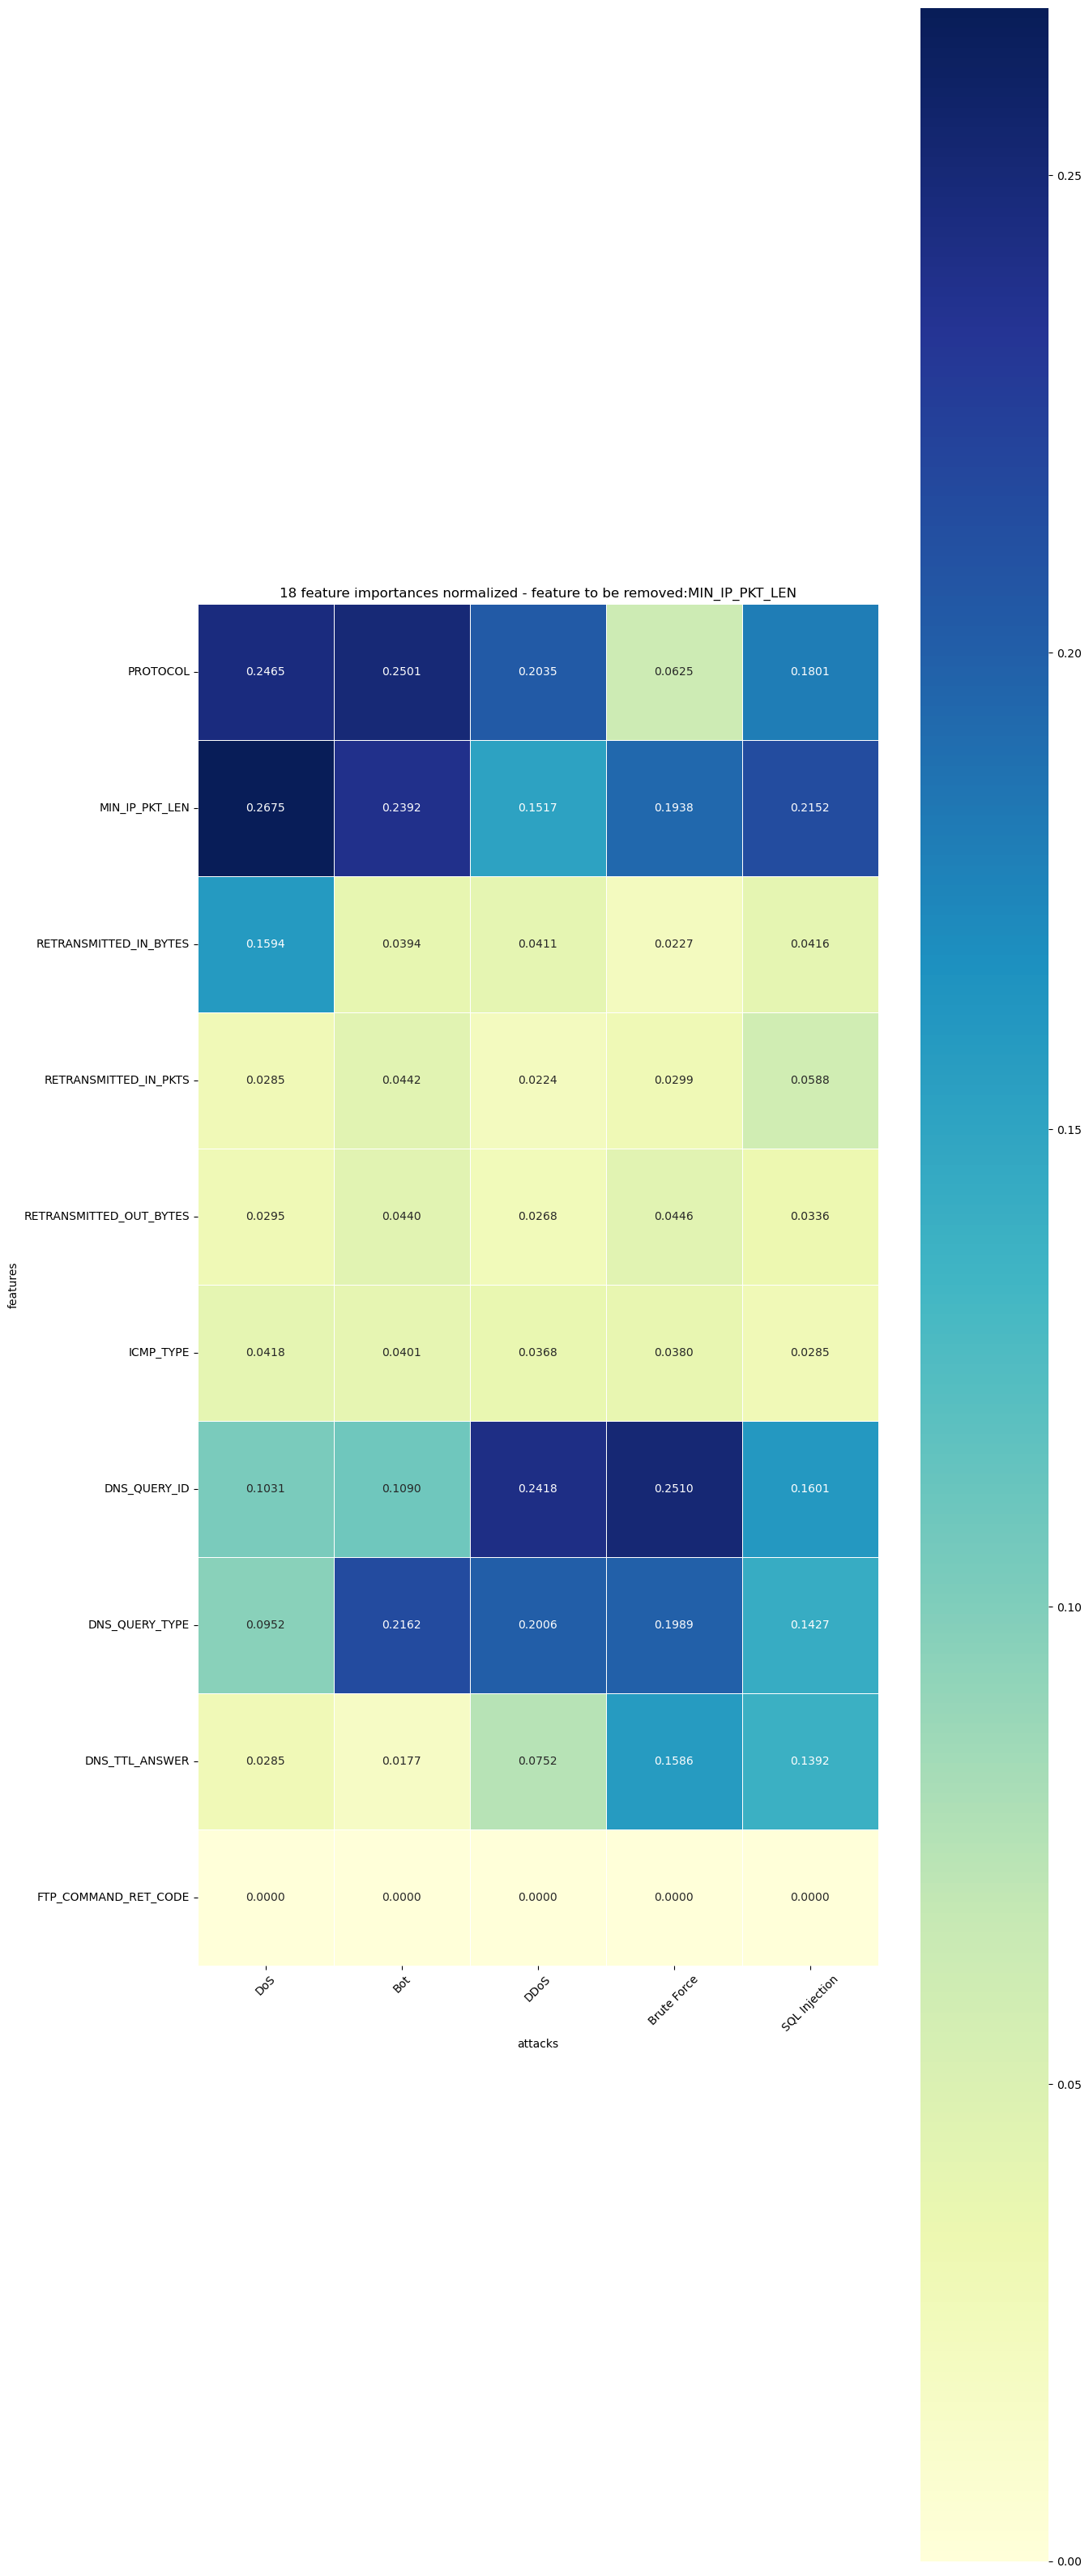

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

weight=0.5
iteration=0
possible_contaminants=[]
while True: #break when 1 of the models has a score lower than 0.8
    print(f"ITERATION: {iteration}")
#     -----------------Train Models-------------------------------
    prepared_result_rows = [] 
    for src_atk_type in attacks[1:]:
        dst_atk_type=src_atk_type
        accuracies = []
        precisions = []
        recalls = []
        importances=[]
        # zs = StandardScaler()
    #     oe=OrdinalEncoder()
        X_train = training_dfs[src_atk_type][training_dfs[src_atk_type].columns[:-1]]
    #     X_train[good_label_cols]=oe.fit_transform(X_train[good_label_cols])
        # X_train = zs.fit_transform(X_train.array.reshape(-1,1))
        y_train = training_dfs[src_atk_type][training_dfs[src_atk_type].columns[-1]]

        X_test = testing_dfs[dst_atk_type][testing_dfs[dst_atk_type].columns[:-1]]
    #     X_test[good_label_cols]=oe.transform(X_test[good_label_cols])

        # X_test = zs.transform(X_test.array.reshape(-1,1))
        y_test = testing_dfs[dst_atk_type][testing_dfs[dst_atk_type].columns[-1]]

        for i in range(6):
            clf=RandomForestClassifier()
            params = {
                                'bootstrap': True,
                                'max_features': 'sqrt',
                                'min_impurity_decrease': 0.0,
                                'min_samples_leaf': 2,
                                'n_estimators': 10,
                                'max_samples': 0.5,
                                'criterion': 'entropy',
                                'n_jobs': -1,
                                }
            clf.set_params(**params)
            clf.fit(X=X_train, y=y_train)

            outputs = clf.predict(X=X_test)
            explainer = shap.TreeExplainer(clf)
            shap_values = explainer.shap_values(X_test)

            importances.append(np.abs(shap_values[1]).mean(axis=0))
            accuracies.append(accuracy_score(y_true=y_test, y_pred=outputs))
            precisions.append(precision_score(y_true=y_test, y_pred=outputs, zero_division=0))
            recalls.append(recall_score(y_true=y_test, y_pred=outputs, zero_division=0))
        prepared_result_row = [
                        src_atk_type,
                        np.mean(importances,axis=0),
                        round(np.mean(accuracies), 3),
                        round(np.std(accuracies), 3),
                        round(np.mean(precisions), 3),
                        round(np.std(precisions), 3),
                        round(np.mean(recalls), 3),
                        round(np.std(recalls), 3),            
        ]
        print([prepared_result_row[0]]+prepared_result_row[2:])
        prepared_result_rows.append(prepared_result_row)
#   -----------------------Analyze Results -------------------------------
    #check if we can continue
    scores=[row[2] for row in prepared_result_rows]
    if any(x < 0.8 for x in scores):
        break

    #normalize importances
    stacked_array_norm = np.stack([row[1]/row[1].sum() for row in prepared_result_rows], axis=1)
    
    #average over all attack classes
    importances=stacked_array_norm.mean(axis=1)
    
    variance=stacked_array_norm.var(axis=1)
    #get the most important (weighted by variance) feature
    weighted_importances=(1-weight)*importances+(weight)*(0.25-variance)
    sorted_indices = np.argsort(weighted_importances)[::-1]
    sorted_labels = [X_test.columns[i] for i in sorted_indices]
    sorted_importances = importances[sorted_indices]
    print(f"top features {sorted_labels[:3]}")
    print(f"top importances {sorted_importances[:3]}")
    print(f" feature to be dropped: {sorted_labels[0]}")
    print(f" correlated features: {[feature_group for feature_group in corr_list if sorted_labels[0] in feature_group]}")
    possible_contaminants.append(sorted_labels[0])
    possible_contaminants+=[feature_group for feature_group in corr_list if sorted_labels[0] in feature_group]
    #create figure
    fig, ax = plt.subplots(figsize=(15, 50))

    # create heatmap with annotations
    sns.heatmap(stacked_array_norm, annot=True, fmt='.4f', cmap='YlGnBu', cbar=True, square=True, linewidths=.5, ax=ax)

    # set title and labels
    ax.set_title(f"{iteration} feature importances normalized - feature to be removed:{sorted_labels[0]}")
    ax.set_xlabel('attacks')
    ax.set_ylabel('features')

    # set x and y ticklabels to categorical labels
    ax.set_xticklabels(attacks[1:],rotation=45)
    ax.set_yticklabels(X_train.columns, rotation=0, ha='right')
    plt.subplots_adjust(left=0.2)
    plt.savefig(f"{iteration}_heatmap_{sorted_labels[0]}.png")

    #remove the feature
    for key,value in training_dfs.items():
        value.drop(columns=[sorted_labels[0]],inplace=True)

    for key,value in testing_dfs.items():
        value.drop(columns=[sorted_labels[0]],inplace=True)
    iteration+=1

In [27]:
possible_contaminants

['L7_PROTO',
 'MIN_TTL',
 ['MIN_TTL', 'MAX_TTL'],
 'TCP_WIN_MAX_IN',
 'FLOW_DURATION_MILLISECONDS',
 'TCP_WIN_MAX_OUT',
 'TCP_FLAGS',
 ['TCP_FLAGS', 'CLIENT_TCP_FLAGS'],
 'NUM_PKTS_128_TO_256_BYTES',
 'IN_BYTES',
 ['IN_BYTES', 'IN_PKTS', 'DURATION_IN', 'NUM_PKTS_UP_TO_128_BYTES'],
 'DURATION_OUT',
 'LONGEST_FLOW_PKT',
 ['LONGEST_FLOW_PKT', 'MAX_IP_PKT_LEN'],
 'SRC_TO_DST_AVG_THROUGHPUT',
 'OUT_BYTES',
 ['OUT_BYTES', 'OUT_PKTS', 'NUM_PKTS_1024_TO_1514_BYTES'],
 'SRC_TO_DST_SECOND_BYTES',
 ['SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES'],
 'DST_TO_SRC_AVG_THROUGHPUT',
 'SERVER_TCP_FLAGS',
 'NUM_PKTS_512_TO_1024_BYTES',
 'NUM_PKTS_256_TO_512_BYTES',
 'SHORTEST_FLOW_PKT',
 'MIN_IP_PKT_LEN']